<a href="https://colab.research.google.com/github/YinWang3026/cv_semantic_segmentation/blob/main/fall2021_image_preprocessing_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fall 2021 Computer Vision Project

In this project, we will implement **Semantics Segmentation** to identify solar panels in aerial images of cities.

We will use **U-net** for our model, and use **Discriminative Loss Function** for back propagation and training

This file contains functions for pre-processing data.

# Data Preparation Overview

To prepare the data as input to our network, we start by generating binary images using the CSVs containing polygon data to plot the polygons associated with PV panels that serves as ground truth. 

The input images (both the original RGB images and the newly-generated binary images) are 5000x5000 pixels, however, this size is too large for passing through the networks. We subdivide the images to 256x256, non-overlapping image subregions, yielding a total of ~40 smaller subimages for each original image.

The subimages are filtered in an effort to balance the data given the relative scarcity of pixels within the PV polygons. First they are filtered to eliminate subimages that don't contain any polygons, and then they are filtered to eliminate subimages that don't meet a minimum threshold of 5% or 10% of their pixels belonging to PV polygons (having pixel value 1). The subimages satisfying these thresholds are saved to the dataset used in training and testing our model. 

City names need to be changed in file names and paths, as well as in the argument used in filtering the CSV values, according to the originating dataset being used. Additionally, the file names associated with a particular city dataset need to be provided as a numpy array of strings. 

In [ ]:
import os
import numpy as np 
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from os import mkdir 
import pandas as pd #using pandas to handle csv
from matplotlib import pyplot
from google.colab.patches import cv2_imshow
from csv import writer 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive/')
### Important Note !!! ###
# Need to add shared folder as a shortcut to My Drive
# https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

# Set directory to /code/ folder
%cd /content/drive/My Drive/CV Project Readings/code/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/.shortcut-targets-by-id/1t2oLTk-cUAQEFAgf6rY0UTw_vjW4c98Q/CV Project Readings/code


##Creating Binary Images

In [ ]:
def create_bin_img(file_name, file_num, im_dim, image):

  sub_im_size = 256
  #Path for reading CSV to support populating binary images
  path ="/content/drive/My Drive/CV Project Readings/code/data/Distributed_Solar_Photovoltaic_Array_Location_and_Extent Data/" #Note - need shortcut to My Drive - https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab
  os.chdir(path)

  #Read csv, filter csv data based on city name and file name to get polygon IDs
  overall_data = pd.read_csv('polygonDataExceptVertices.csv')
  skimmed_data = overall_data[overall_data["city"] == "Modesto"]
  sub_skimmed_data = skimmed_data[skimmed_data["image_name"] == file_name]

  #polygon IDs for a given city and file name
  ids = np.array(sub_skimmed_data["polygon_id"])

  #read csv containing pixel coordinates 
  pixel_data = pd.read_csv('polygonVertices_PixelCoordinates.csv')
  skimmed_pixel_data = np.zeros((len(ids), int(np.shape(pixel_data)[1])))

  #Filter pixel data using polygon IDs
  for i in range(0, len(ids)):
    skimmed_pixel_data[i,:] = pixel_data[pixel_data['polygon_id'] == ids[i] ]

  #print(np.shape(skimmed_pixel_data))

  #Define array shape using maximimum number of polygon vertices
  max_number_vert_coords = 2*int(np.max(skimmed_pixel_data[:,1])) +2

  subset_vertices = np.zeros((len(ids),max_number_vert_coords))

  #print(np.shape(subset_vertices))
  #print(np.shape(skimmed_pixel_data))

  for i in range(len(ids)):
    for j in range(max_number_vert_coords):
      subset_vertices[i,j] = skimmed_pixel_data[i,j+2]

  #print(np.shape(subset_vertices))

  regroup_vertices = np.zeros((int(np.shape(subset_vertices)[0]),int(np.shape(subset_vertices)[1]/2),2))
  for i in range(0,int(np.shape(subset_vertices)[0])):
    regroup_vertices[i,:,:] = list(subset_vertices[i].reshape((int(np.shape(subset_vertices)[1]/2),2)))


  for i in range(0,int(np.shape(subset_vertices)[0])):
    for j in range(0,int(np.shape(regroup_vertices)[2])):
      regroup_vertices[i,:,j] = list(regroup_vertices[i,:,j])

  #define black background image to be populated with white polygons
  im_bg = np.zeros((5000, 5000)) 

  #Populating binary image with polygons
  for i in range(0,int(np.shape(regroup_vertices)[0])):
    subset = regroup_vertices[i,:,:]
    nan_array = np.isnan(subset[:,0])
    no_nans =~ nan_array
    new_array = list(np.floor(subset[no_nans,:]).astype(int))
    new_list = [l.tolist() for l in new_array]
    cv2.fillPoly(im_bg, pts=[np.array(new_list)], color=255)
    if int(np.shape(regroup_vertices)[0]) == 0:
      im_bg = im_bg


  #cv2_imshow(im_bg) #uncomment to view image as generated

  #save image to appropriate folder, named based on city; need to change file name accordingly
  path_output = "/content/drive/My Drive/CV Project Readings/code/data/Modesto_Binary/"
  cv2.imwrite(path_output+'modesto_'+file_num+'_bin.tif', np.uint64(im_bg)) 

In [ ]:
#These lists capture which images do not contain any polygons and need to be excluded from some of the loops below
#Modesto - 0 polygons in image 5, 0 polygons in image 14
#Stockton - 0 polygons in image 20, 25, 32, 33, 34, 51, 54, 55

#Array of image file names
modesto_file_list = ['10sfg735670','10sfg735685','10sfg750655','10sfg750670','10sfg750685','10sfg765655','10sfg765670','10sfg765685','10sfg780655','10sfg780670','10sfg780685','10sfg795655','10sfg795670','10sfg795685','10sfg810655','10sfg810670','10sfg810685','10sfg825655','10sfg825670','10sfg825685']
#stockton_file_list = ['10sfh465045','10sfh465030','10sfh465015','10sfh450120','10sfh450105','10sfh450090','10sfh450075','10sfh450060','10sfh450045','10sfh450030','10sfh450015','10sfh450000','10sfh435120','10sfh435105','10sfh435090','10sfh435075','10sfh435060','10sfh435045','10sfh420120','10sfh420105','10sfh420090','10sfh420075','10sfg555985','10sfg555970','10sfg555955','10sfg540985','10sfg540970','10sfg540955','10sfg525985','10sfg525970','10sfg525955','10sfg510985','10sfg510970','10sfg510955','10sfg495985','10sfg495970','10sfg495955','10sfg480985','10sfg480970','10sfg480955','10sfg465985','10sfg465970','10sfh510105','10sfh465075','10sfh525075','10sfh510030','10sfh510045','10sfh540075','10sfh510135','10sfh540060','10sfh480045','10sfh480120','10sfh525015','10sfh555000','10sfh480000','10sfh495120','10sfh495060','10sfh510120','10sfh495030','10sfh540030','10sfh525135','10sfh495105','10sfh480030','10sfh525045','10sfh480015','10sfh495090','10sfh465105','10sfh495045','10sfh525000','10sfh495015','10sfh465120','10sfh480060','10sfh465060','10sfh540015','10sfh495135','10sfh510060','10sfh480075','10sfh510015','10sfh495000','10sfh510090','10sfh540000','10sfh540045','10sfh465090','10sfh525030','10sfh525090','10sfh480105','10sfh480090','10sfh495075','10sfh525120','10sfh510000','10sfh525105','10sfh510075','10sfh525060']

#function to loop over files names to generate binary images; need to skip file names that don't contain any polygons
#need to change directory, file list input based on city name
def loop_ims_bin(modesto_file_list):
  path_input ="/content/drive/My Drive/CV Project Readings/code/data/Modesto_Aerial_USGS_Imagery/"
  for i in range(15, len(modesto_file_list)): #len(stockton_file_list)): 
    file_name = modesto_file_list[i]
    file_num = file_name[5:]
    image = cv2.imread(path_input+file_name+'.tif', cv2.IMREAD_UNCHANGED)  
    im_dim = np.shape(image)
    print(np.shape(im_dim))
    create_bin_img(file_name, file_num, im_dim, image)

(3,)
Modesto data shape (582, 18)
Modesto file data shape (15, 18)
(15, 294)
(15, 60)
(15, 294)
(15, 60)


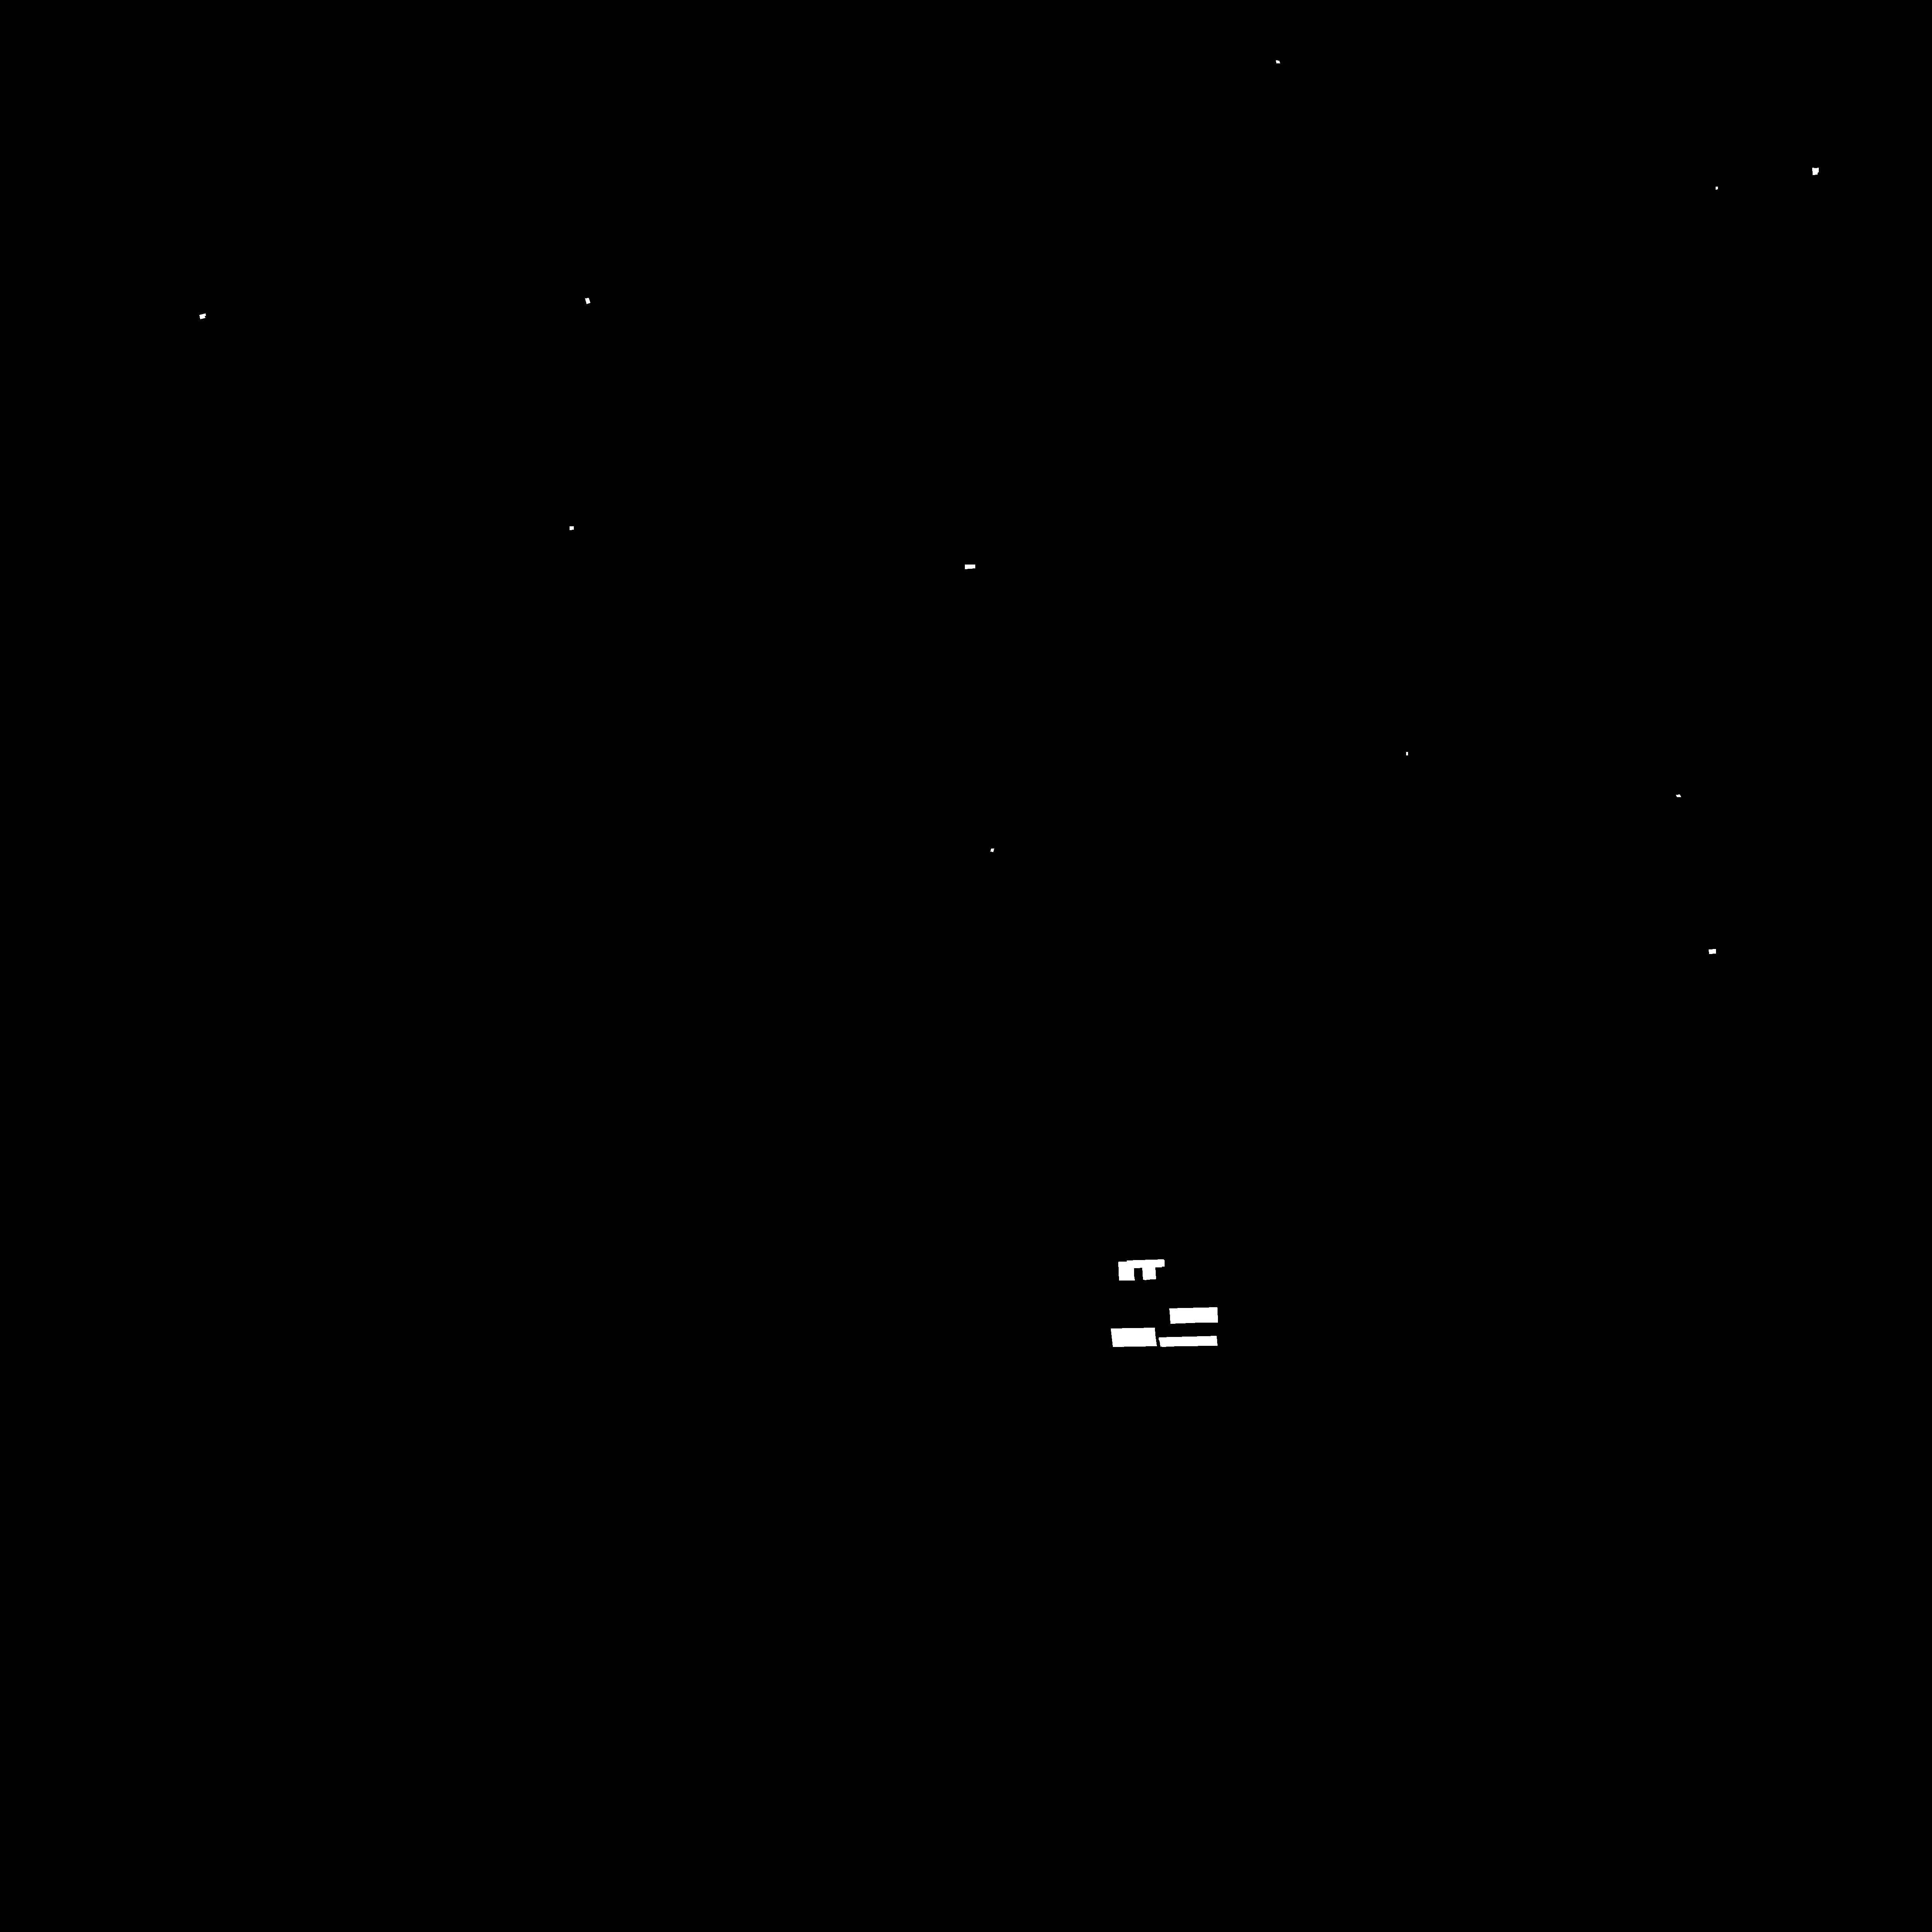

(3,)
Modesto data shape (582, 18)
Modesto file data shape (156, 18)
(156, 294)
(156, 70)
(156, 294)
(156, 70)


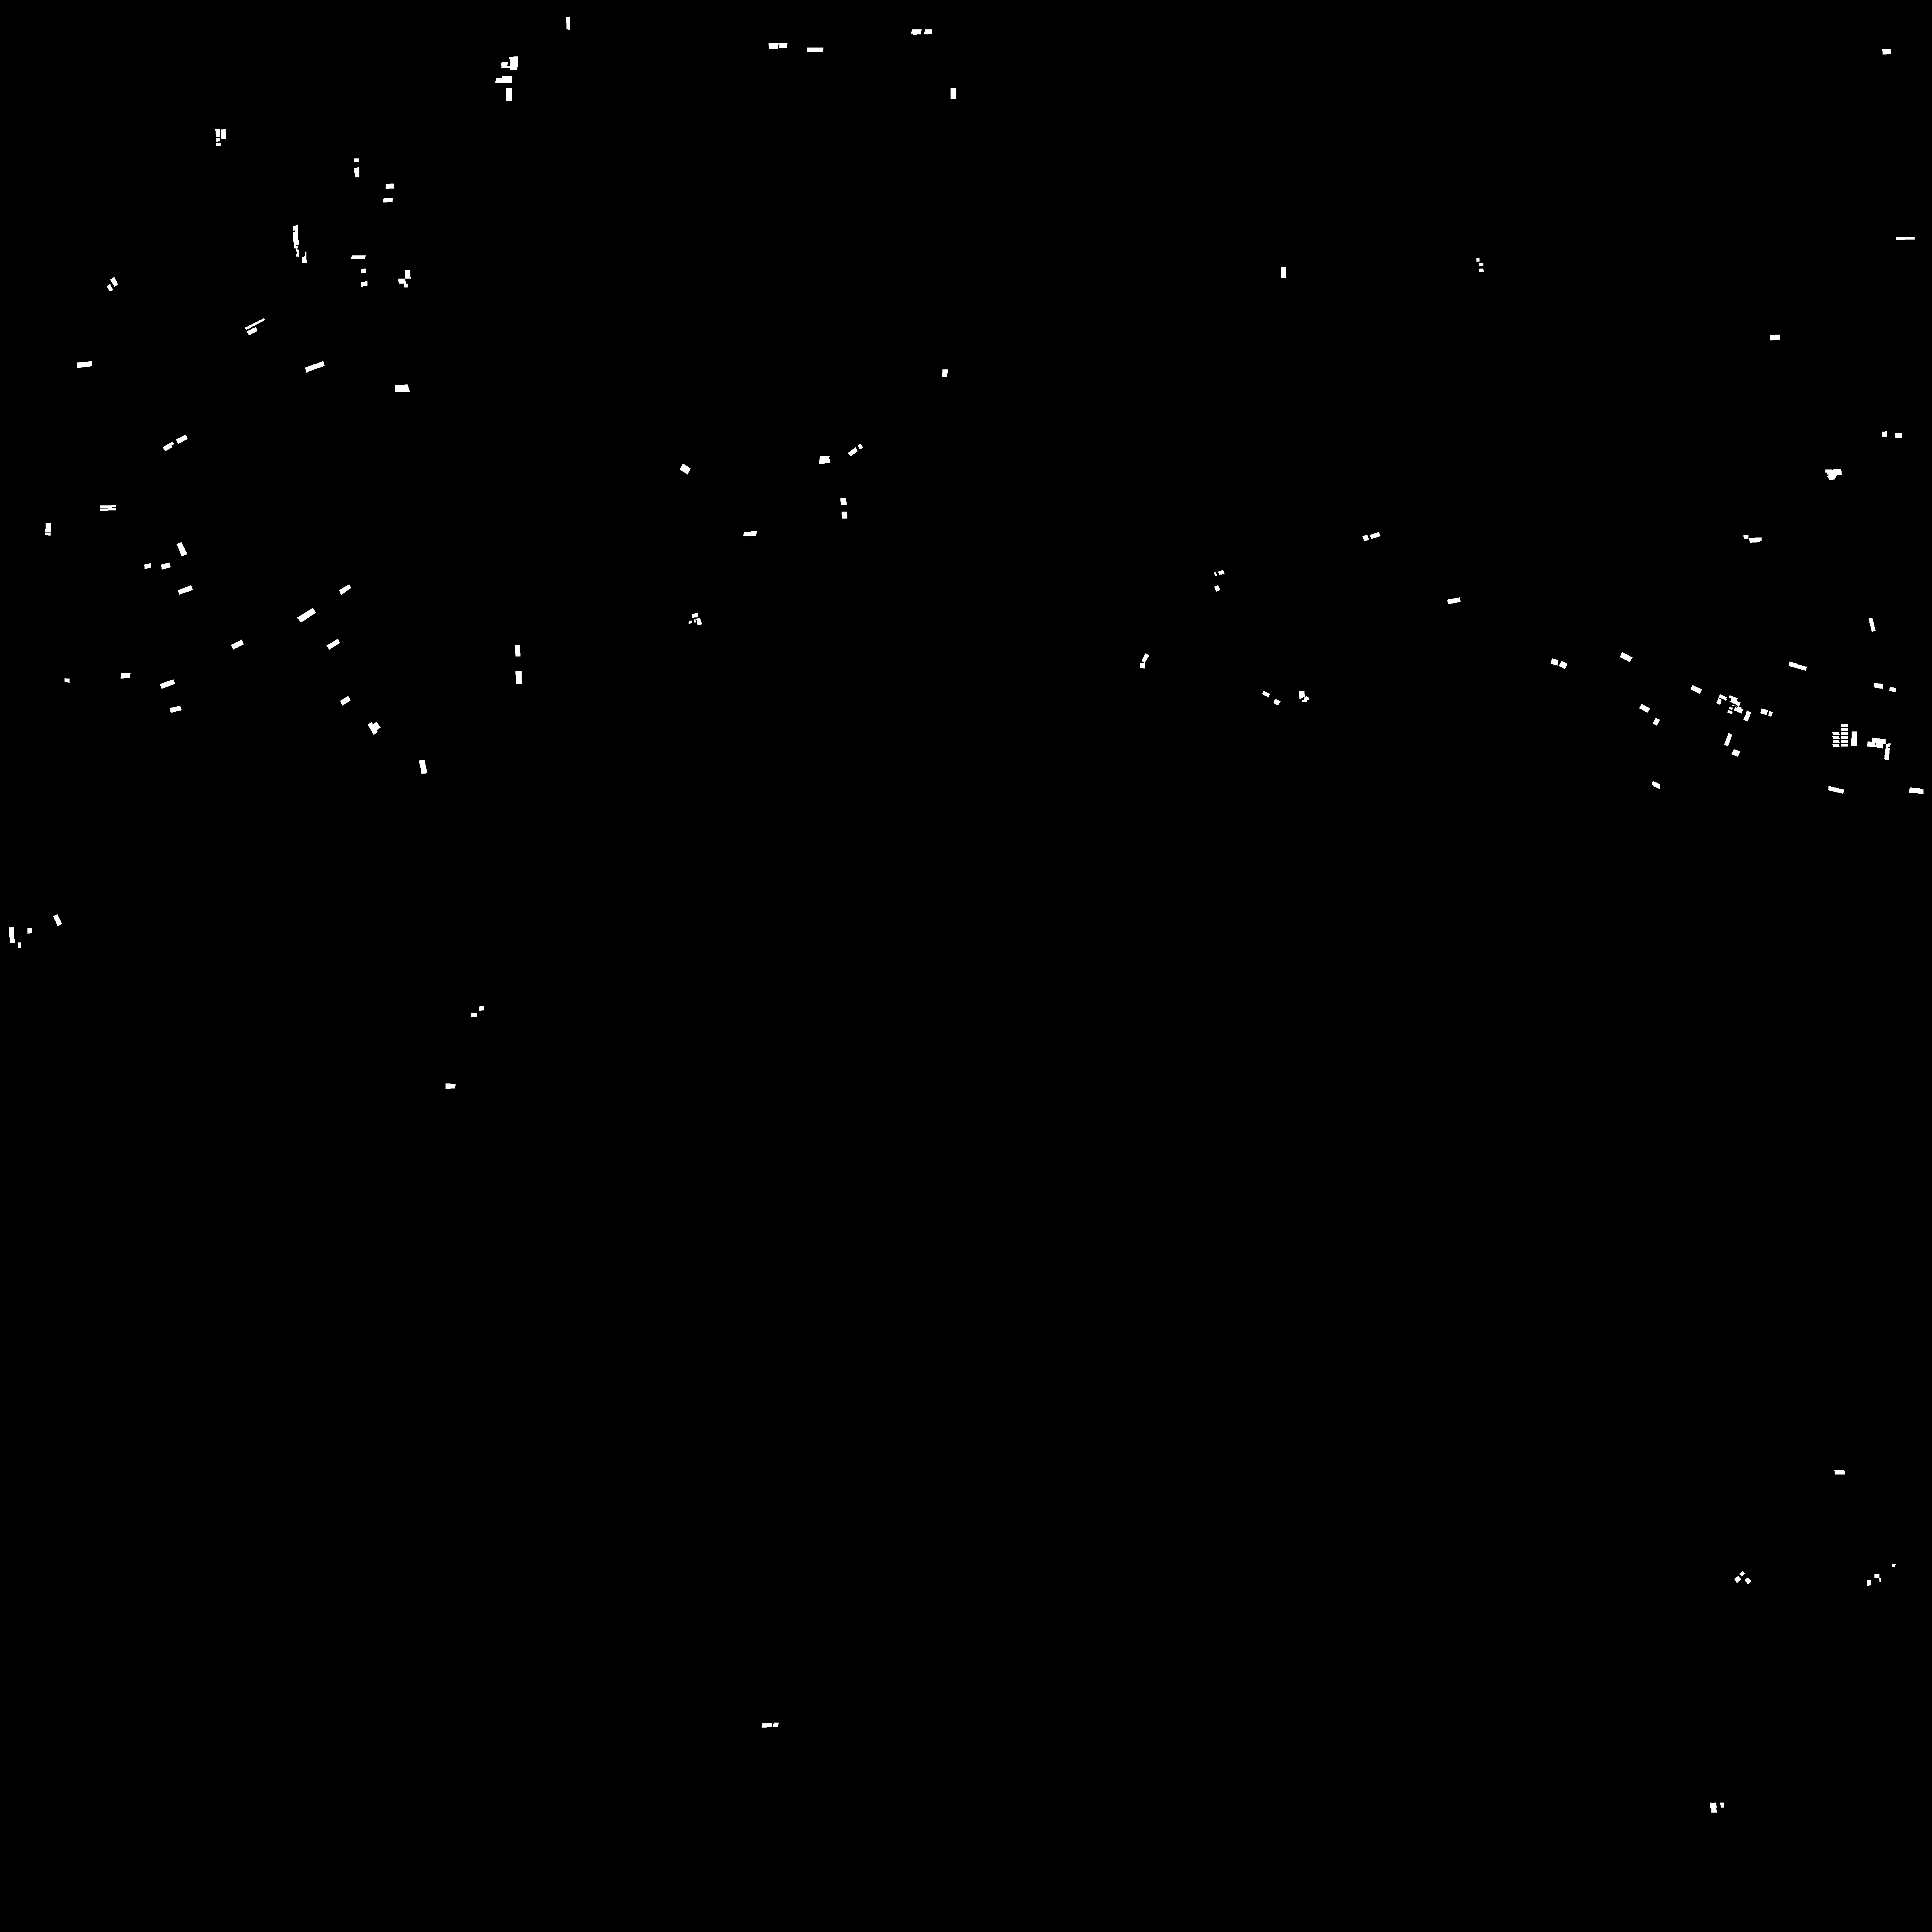

(3,)
Modesto data shape (582, 18)
Modesto file data shape (20, 18)
(20, 294)
(20, 162)
(20, 294)
(20, 162)


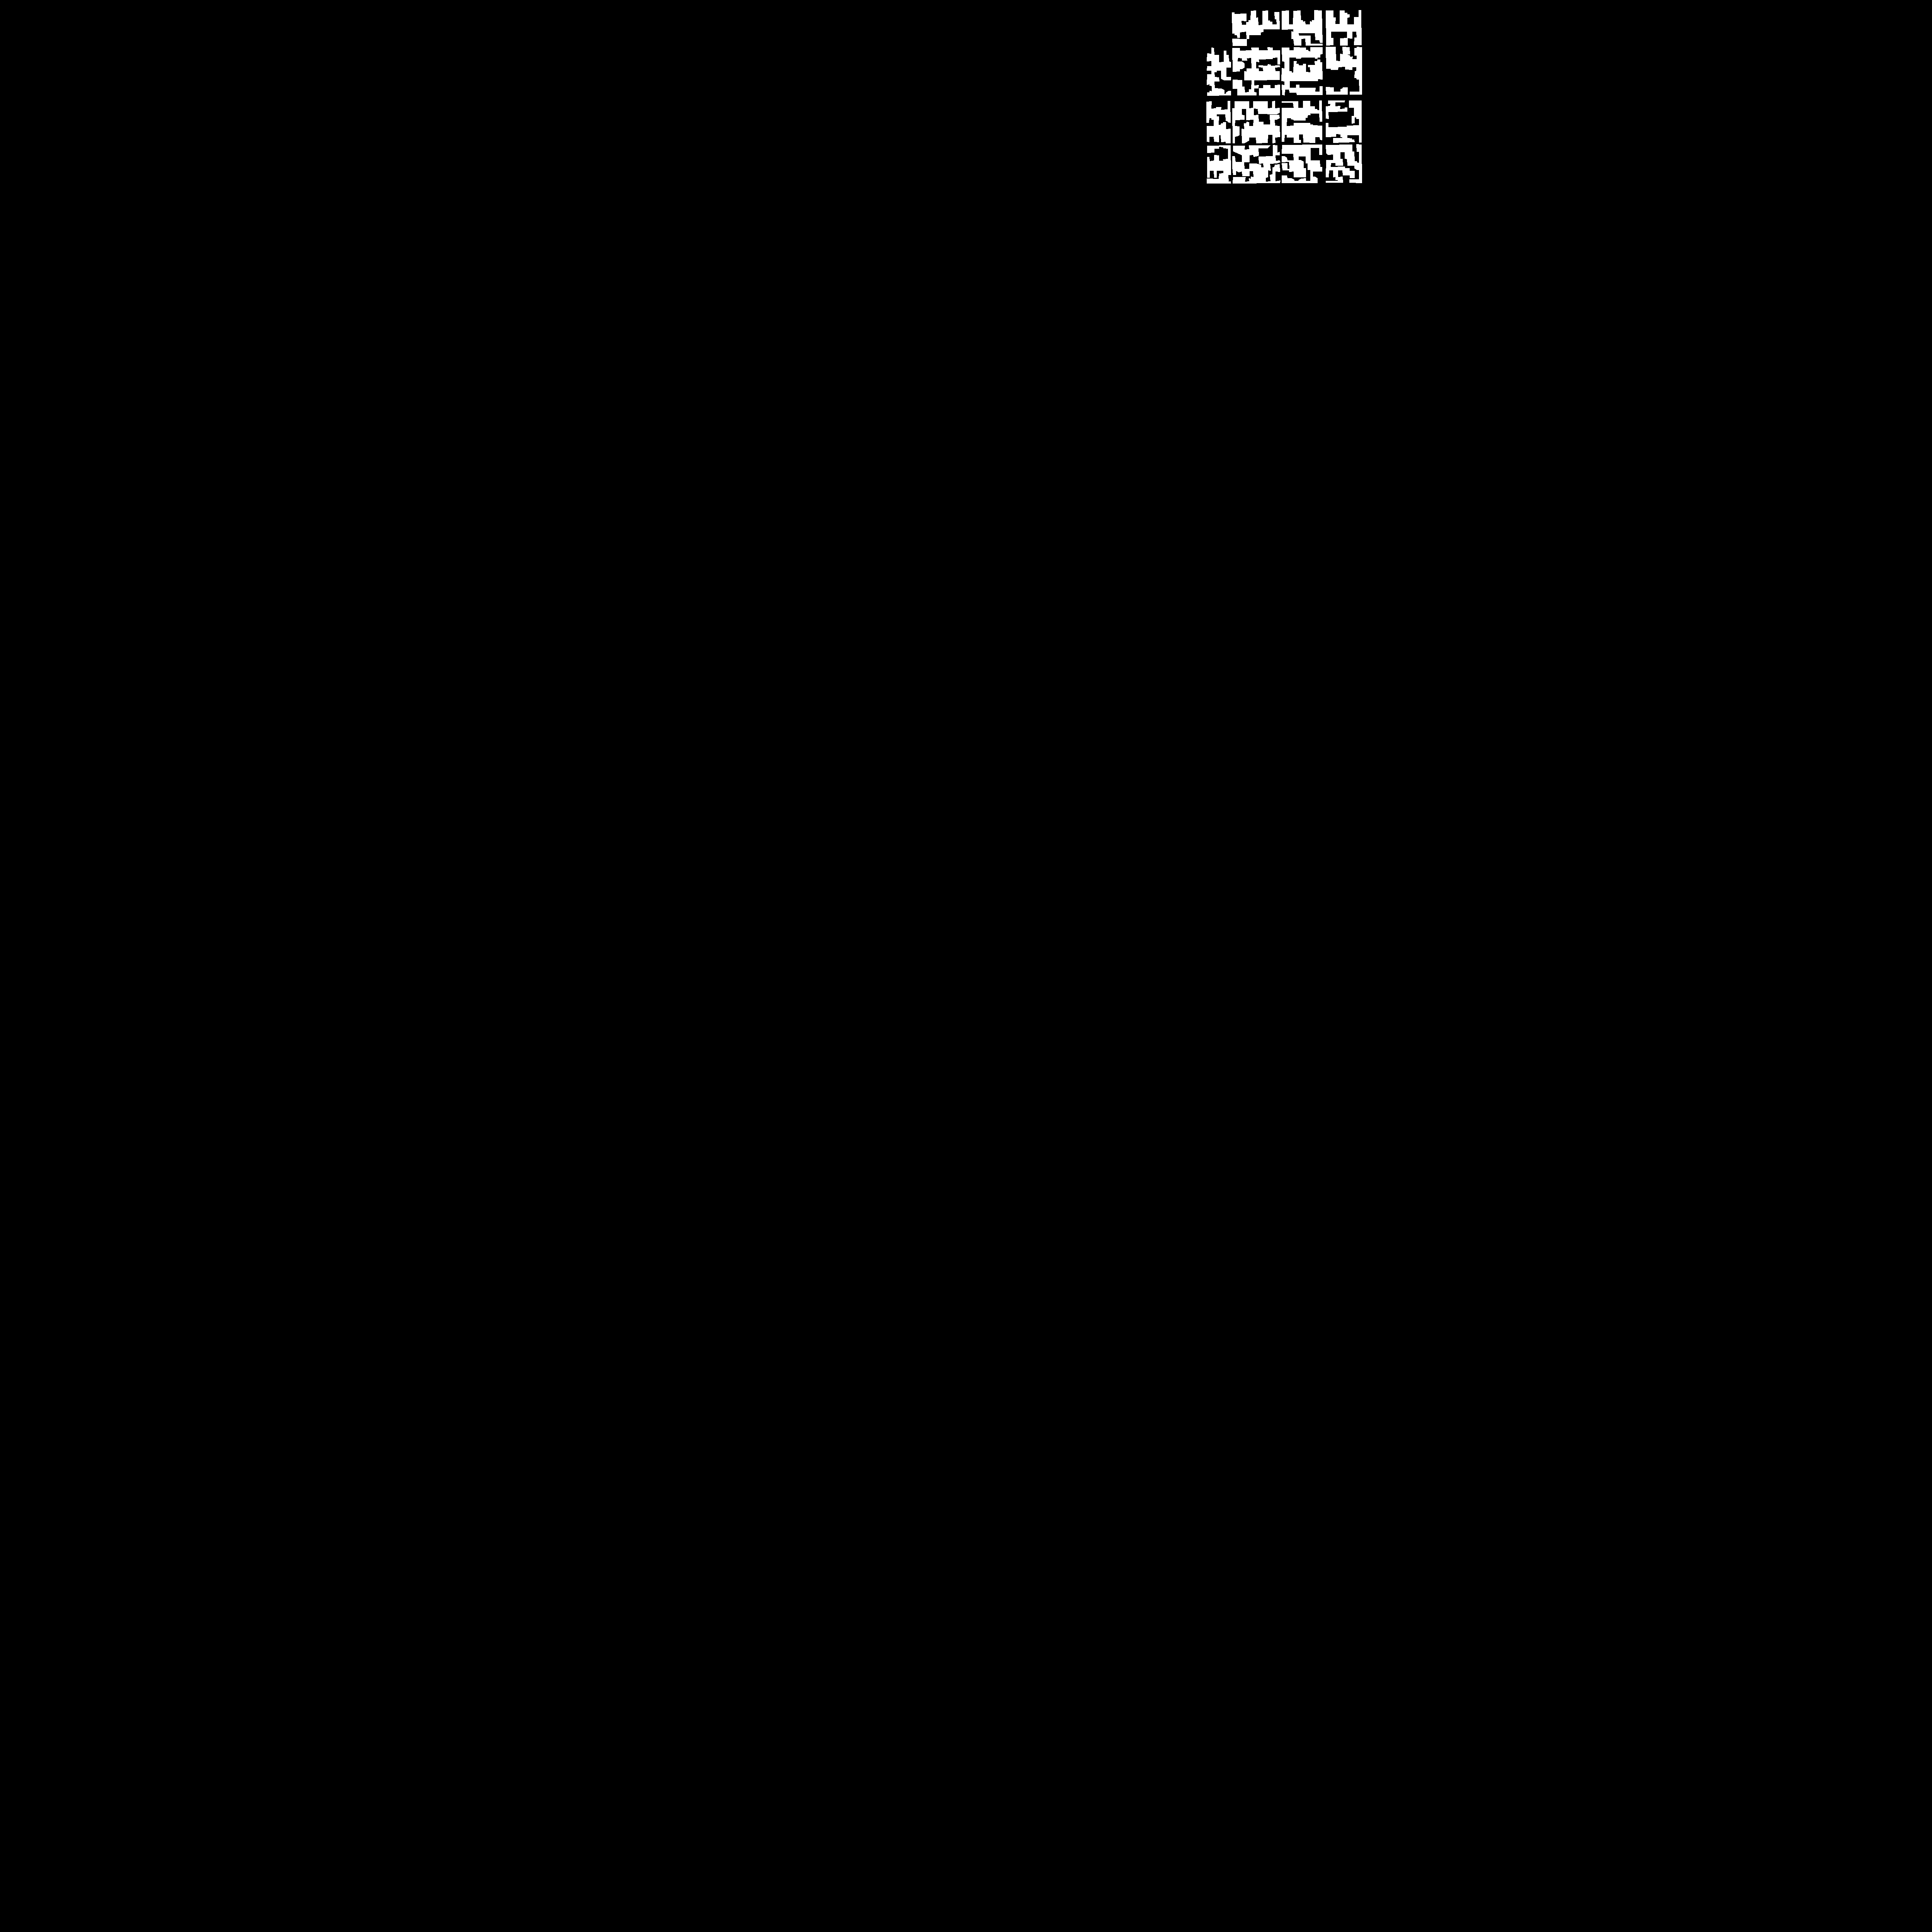

(3,)
Modesto data shape (582, 18)
Modesto file data shape (10, 18)
(10, 294)
(10, 34)
(10, 294)
(10, 34)


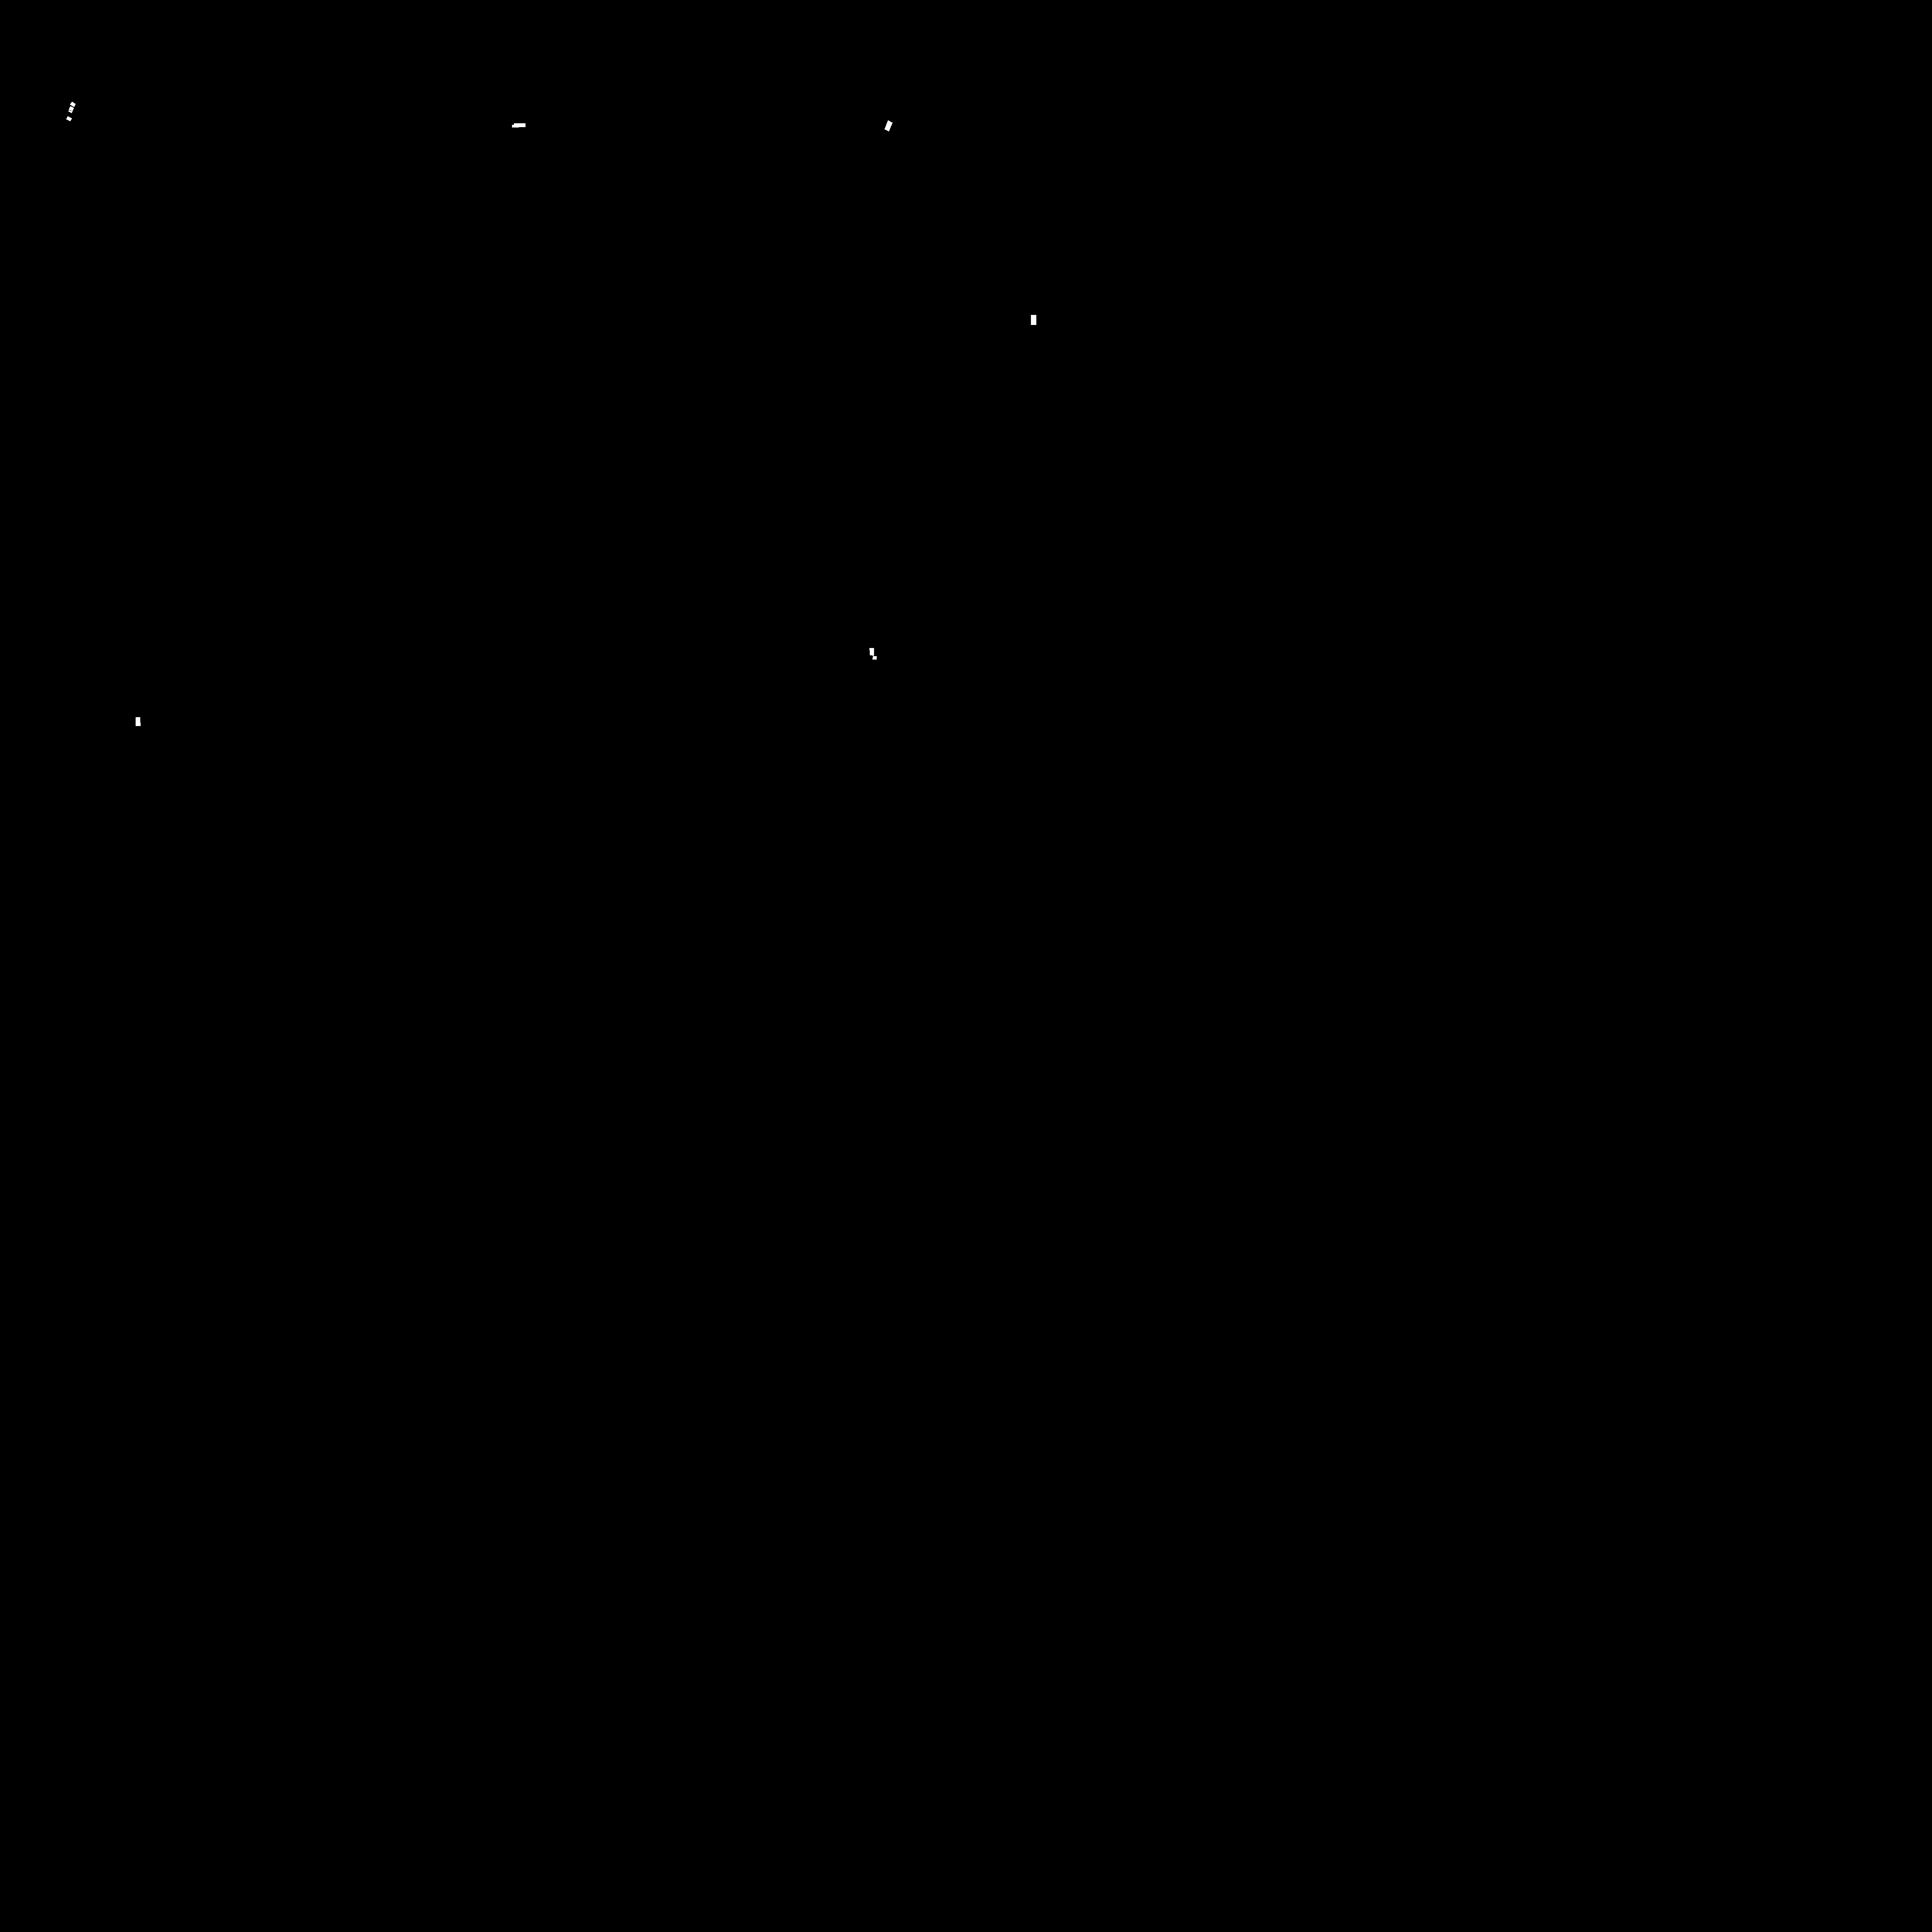

(3,)
Modesto data shape (582, 18)
Modesto file data shape (37, 18)
(37, 294)
(37, 54)
(37, 294)
(37, 54)


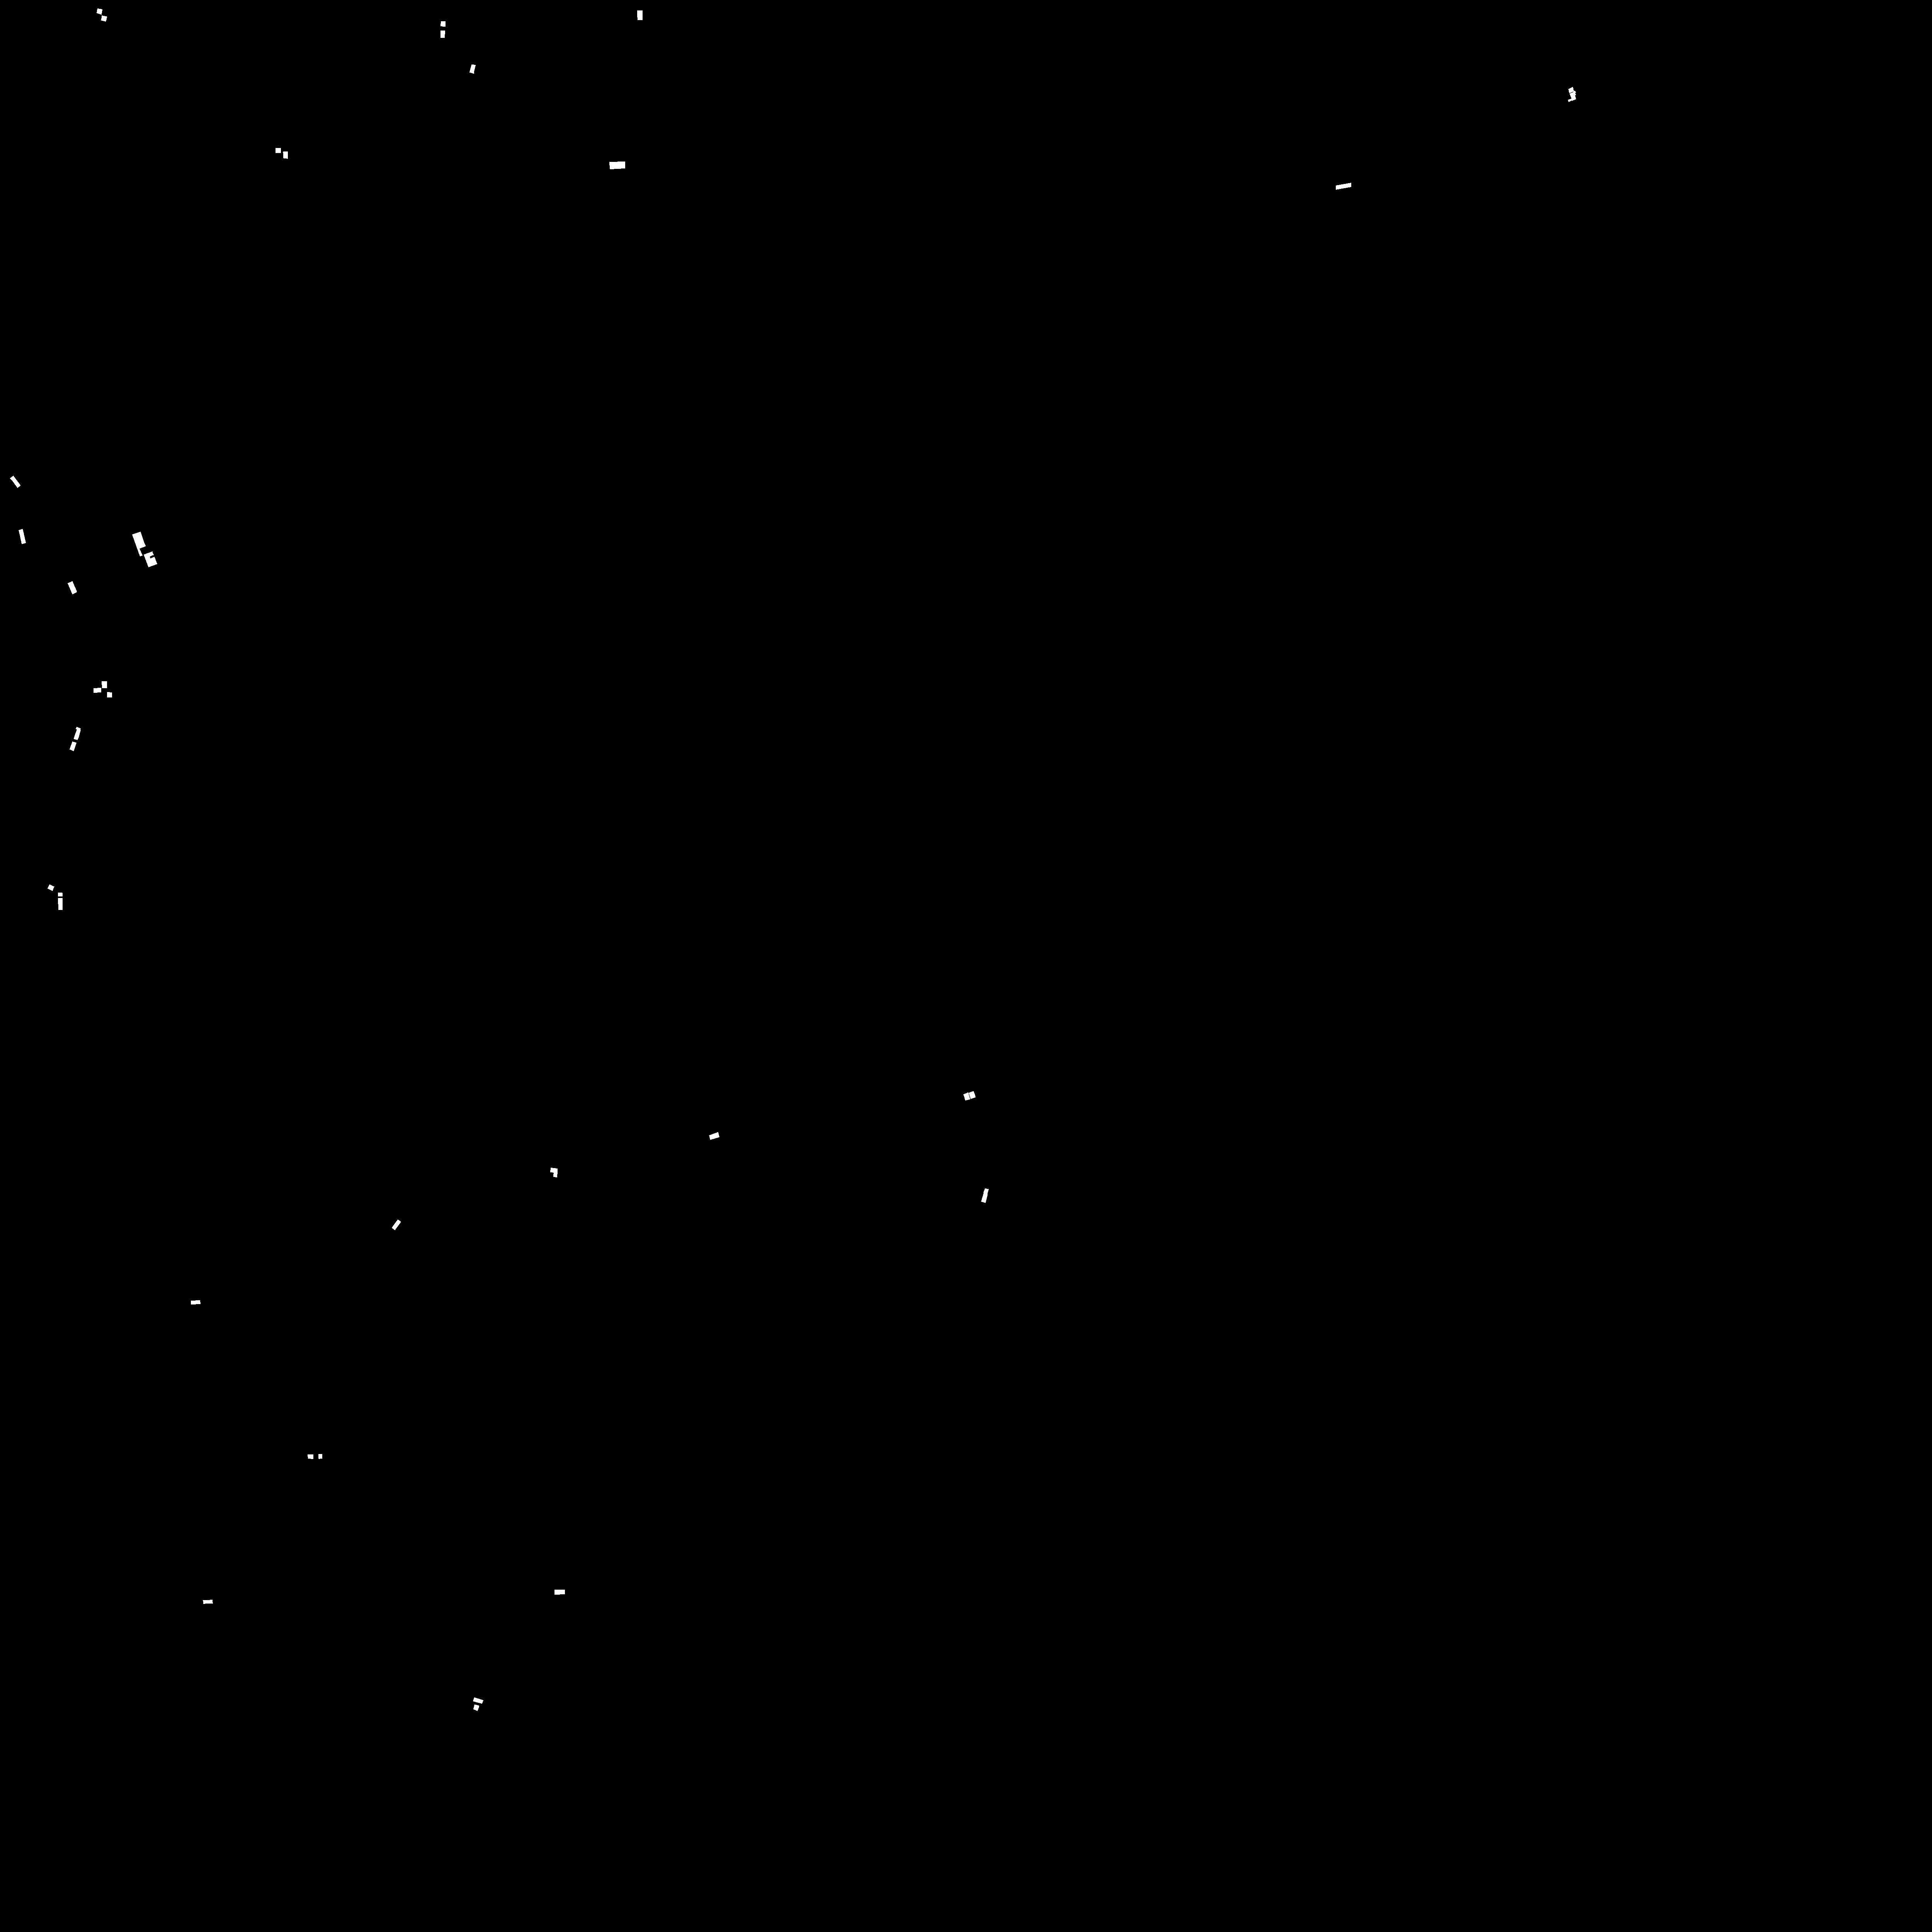

In [ ]:
#execute looping function to generate binary images
loop_ims_bin(modesto_file_list)

In [ ]:
#Create empty binary images as place-holder for the images that contain no polygons

#Modesto - 0 polygons in image 5, 0 polygons in image 14
#Stockton - 0 polygons in image 20, 25, 32, 33, 34, 51, 54, 55

modesto_file_list = ['10sfg735670','10sfg735685','10sfg750655','10sfg750670','10sfg750685','10sfg765655','10sfg765670','10sfg765685','10sfg780655','10sfg780670','10sfg780685','10sfg795655','10sfg795670','10sfg795685','10sfg810655','10sfg810670','10sfg810685','10sfg825655','10sfg825670','10sfg825685']
empty_modesto_file_list = [modesto_file_list[5], modesto_file_list[14]]
#stockton_file_list = ['10sfh465045','10sfh465030','10sfh465015','10sfh450120','10sfh450105','10sfh450090','10sfh450075','10sfh450060','10sfh450045','10sfh450030','10sfh450015','10sfh450000','10sfh435120','10sfh435105','10sfh435090','10sfh435075','10sfh435060','10sfh435045','10sfh420120','10sfh420105','10sfh420090','10sfh420075','10sfg555985','10sfg555970','10sfg555955','10sfg540985','10sfg540970','10sfg540955','10sfg525985','10sfg525970','10sfg525955','10sfg510985','10sfg510970','10sfg510955','10sfg495985','10sfg495970','10sfg495955','10sfg480985','10sfg480970','10sfg480955','10sfg465985','10sfg465970','10sfh510105','10sfh465075','10sfh525075','10sfh510030','10sfh510045','10sfh540075','10sfh510135','10sfh540060','10sfh480045','10sfh480120','10sfh525015','10sfh555000','10sfh480000','10sfh495120','10sfh495060','10sfh510120','10sfh495030','10sfh540030','10sfh525135','10sfh495105','10sfh480030','10sfh525045','10sfh480015','10sfh495090','10sfh465105','10sfh495045','10sfh525000','10sfh495015','10sfh465120','10sfh480060','10sfh465060','10sfh540015','10sfh495135','10sfh510060','10sfh480075','10sfh510015','10sfh495000','10sfh510090','10sfh540000','10sfh540045','10sfh465090','10sfh525030','10sfh525090','10sfh480105','10sfh480090','10sfh495075','10sfh525120','10sfh510000','10sfh525105','10sfh510075','10sfh525060']
#empty_stockton_file_list = [stockton_file_list[20],stockton_file_list[25],stockton_file_list[32],stockton_file_list[33],stockton_file_list[34],stockton_file_list[51],stockton_file_list[54], stockton_file_list[55]]

for i in range(0, len(empty_modesto_file_list)):
  file_name = empty_modesto_file_list[i]
  file_num = file_name[5:]
  image = np.zeros((5000,5000))
  im_dim = np.shape(image)
  path_output = "/content/drive/My Drive/CV Project Readings/code/data/Modesto_Binary/"
  cv2.imwrite(path_output+'modesto_'+file_num+'_bin.tif', np.uint64(image)) #write out new images 

##Rotating Original Images for Data Augmentation

In [ ]:
def rotate_im():
  path_input ="/content/drive/My Drive/CV Project Readings/code/data/Modesto_Aerial_USGS_Imagery/"
  path_output = "/content/drive/My Drive/CV Project Readings/code/data/Modesto_Aerial_USGS_Imagery_Rotated/"
  #os.mkdir(path_output) #Include as necessary
  
  modesto_file_list = ['10sfg735670','10sfg735685','10sfg750655','10sfg750670','10sfg750685','10sfg765655','10sfg765670','10sfg765685','10sfg780655','10sfg780670','10sfg780685','10sfg795655','10sfg795670','10sfg795685','10sfg810655','10sfg810670','10sfg810685','10sfg825655','10sfg825670','10sfg825685']
  #stockton_file_list = ['10sfh465045','10sfh465030','10sfh465015','10sfh450120','10sfh450105','10sfh450090','10sfh450075','10sfh450060','10sfh450045','10sfh450030','10sfh450015','10sfh450000','10sfh435120','10sfh435105','10sfh435090','10sfh435075','10sfh435060','10sfh435045','10sfh420120','10sfh420105','10sfh420090','10sfh420075','10sfg555985','10sfg555970','10sfg555955','10sfg540985','10sfg540970','10sfg540955','10sfg525985','10sfg525970','10sfg525955','10sfg510985','10sfg510970','10sfg510955','10sfg495985','10sfg495970','10sfg495955','10sfg480985','10sfg480970','10sfg480955','10sfg465985','10sfg465970','10sfh510105','10sfh465075','10sfh525075','10sfh510030','10sfh510045','10sfh540075','10sfh510135','10sfh540060','10sfh480045','10sfh480120','10sfh525015','10sfh555000','10sfh480000','10sfh495120','10sfh495060','10sfh510120','10sfh495030','10sfh540030','10sfh525135','10sfh495105','10sfh480030','10sfh525045','10sfh480015','10sfh495090','10sfh465105','10sfh495045','10sfh525000','10sfh495015','10sfh465120','10sfh480060','10sfh465060','10sfh540015','10sfh495135','10sfh510060','10sfh480075','10sfh510015','10sfh495000','10sfh510090','10sfh540000','10sfh540045','10sfh465090','10sfh525030','10sfh525090','10sfh480105','10sfh480090','10sfh495075','10sfh525120','10sfh510000','10sfh525105','10sfh510075','10sfh525060']
  
  #need to change file list input, data path based on city data being processed

  #save rotated images
  for i in range(0, len(modesto_file_list)):  #len(stockton_file_list)):
    file_name = modesto_file_list[i]
    image = cv2.imread(path_input+file_name+'.tif', cv2.IMREAD_UNCHANGED) 
    image_rot90 = cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(path_output+file_name+'_rot90cw.tif',image_rot90)
    image_rot180 = cv2.rotate(image,cv2.ROTATE_180)
    cv2.imwrite(path_output+file_name+'_rot180.tif',image_rot180)

In [ ]:
#Execute function rotating original images
rotate_im()

##Rotation of Binary Images

In [ ]:
#Performs rotation and saving of newly-rotated binary images
#Written as a separate function based on different input image (binary) and output file names

#Modesto - 0 polygons in image 5, 0 polygons in image 14
#Stockton - 0 polygons in image 20, 25, 32, 33, 34, 51, 54, 55

def rotate_bin_im():
  path_input ="/content/drive/My Drive/CV Project Readings/code/data/Modesto_Binary/"
  path_output = "/content/drive/My Drive/CV Project Readings/code/data/Modesto_Binary_Rotated/"
  #os.mkdir(path_output) #Include as necessary

  #stockton_file_list = ['10sfh465045','10sfh465030','10sfh465015','10sfh450120','10sfh450105','10sfh450090','10sfh450075','10sfh450060','10sfh450045','10sfh450030','10sfh450015','10sfh450000','10sfh435120','10sfh435105','10sfh435090','10sfh435075','10sfh435060','10sfh435045','10sfh420120','10sfh420105','10sfh420090','10sfh420075','10sfg555985','10sfg555970','10sfg555955','10sfg540985','10sfg540970','10sfg540955','10sfg525985','10sfg525970','10sfg525955','10sfg510985','10sfg510970','10sfg510955','10sfg495985','10sfg495970','10sfg495955','10sfg480985','10sfg480970','10sfg480955','10sfg465985','10sfg465970','10sfh510105','10sfh465075','10sfh525075','10sfh510030','10sfh510045','10sfh540075','10sfh510135','10sfh540060','10sfh480045','10sfh480120','10sfh525015','10sfh555000','10sfh480000','10sfh495120','10sfh495060','10sfh510120','10sfh495030','10sfh540030','10sfh525135','10sfh495105','10sfh480030','10sfh525045','10sfh480015','10sfh495090','10sfh465105','10sfh495045','10sfh525000','10sfh495015','10sfh465120','10sfh480060','10sfh465060','10sfh540015','10sfh495135','10sfh510060','10sfh480075','10sfh510015','10sfh495000','10sfh510090','10sfh540000','10sfh540045','10sfh465090','10sfh525030','10sfh525090','10sfh480105','10sfh480090','10sfh495075','10sfh525120','10sfh510000','10sfh525105','10sfh510075','10sfh525060']
  modesto_file_list = ['10sfg735670','10sfg735685','10sfg750655','10sfg750670','10sfg750685','10sfg765655','10sfg765670','10sfg765685','10sfg780655','10sfg780670','10sfg780685','10sfg795655','10sfg795670','10sfg795685','10sfg810655','10sfg810670','10sfg810685','10sfg825655','10sfg825670','10sfg825685']
 
  #Loops through file names, needing to skip those without any polygons
  #Saves rotated binary images
  for i in range(15, len(modesto_file_list)): #len(modesto_file_list)):
    file_name = modesto_file_list[i]
    file_num = file_name[5:]
    image = cv2.imread(path_input+'modesto_'+file_num+'_bin.tif', cv2.IMREAD_UNCHANGED) 
    image_rot180 = cv2.rotate(image,cv2.ROTATE_180)
    #cv2_imshow(image_rot180) #Uncomment to view rotated binary images
    cv2.imwrite(path_output+'modesto_'+file_num+'_bin_rot180.tif',image_rot180)
    image_rot90 = cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
    #cv2_imshow(image_rot90) #Uncomment to view rotated binary images
    cv2.imwrite(path_output+'modesto_'+file_num+'_bin_rot90cw.tif',image_rot90)


(5000, 5000)
(5000, 5000)


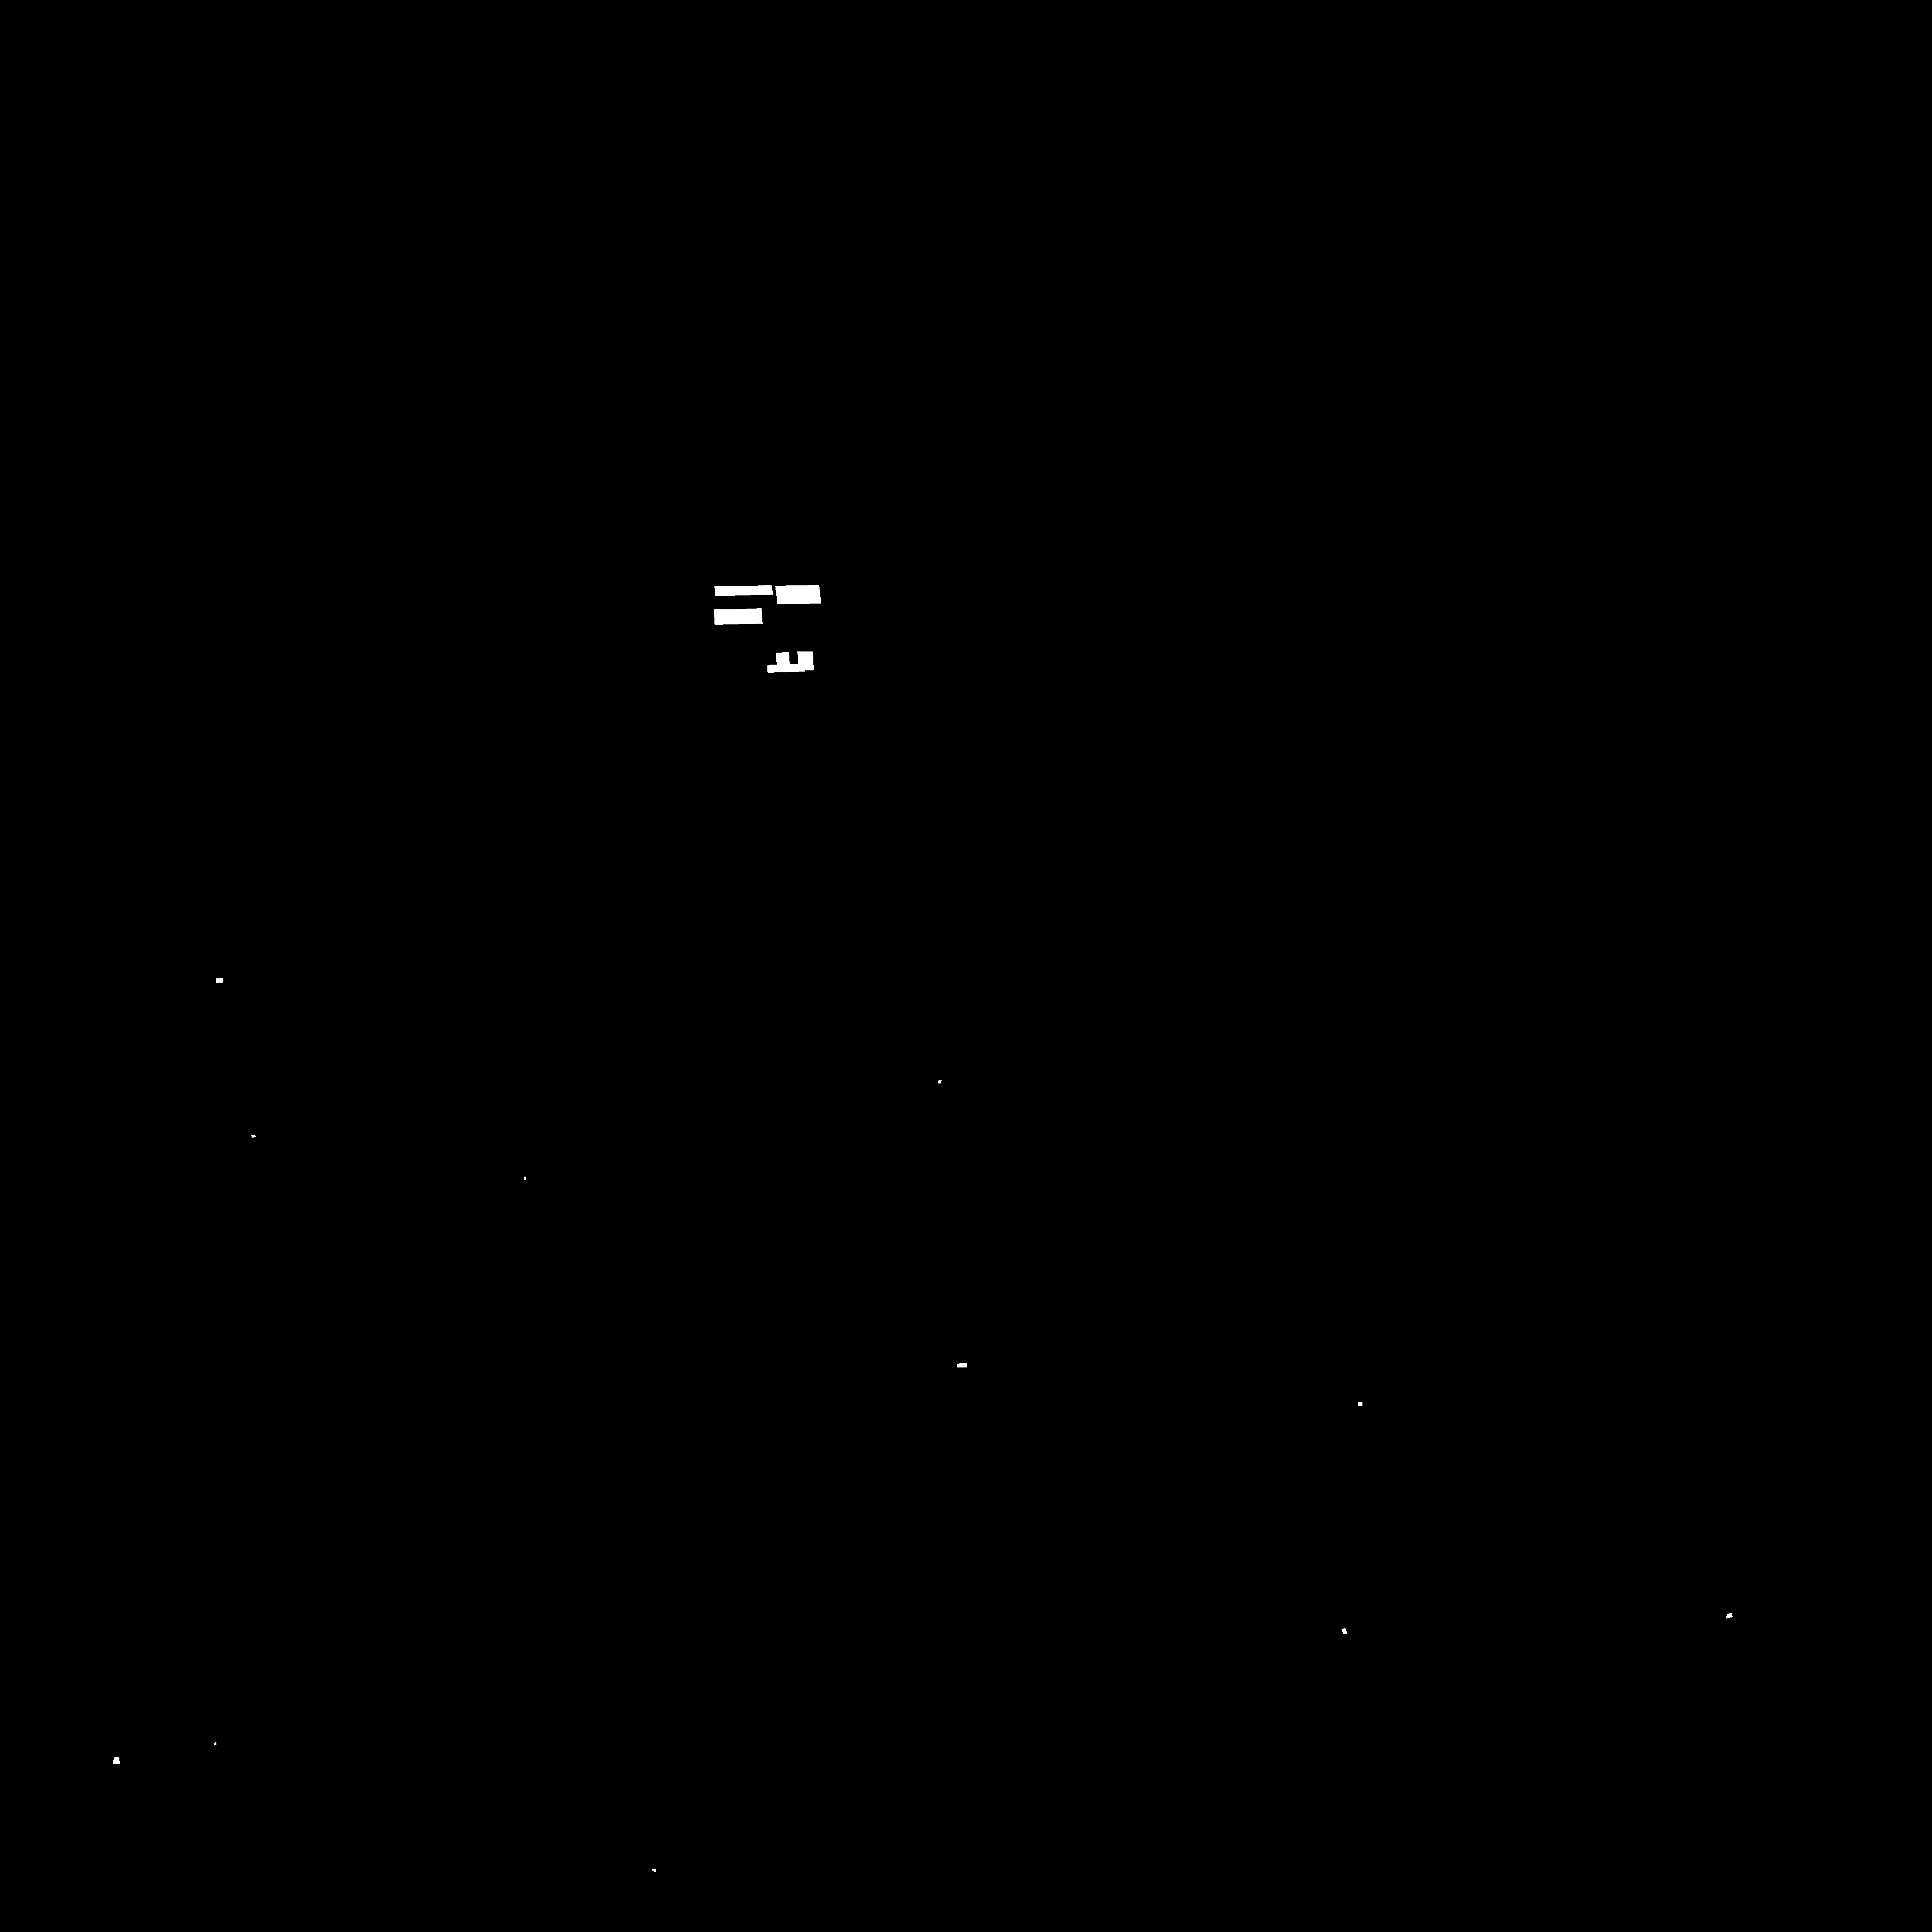

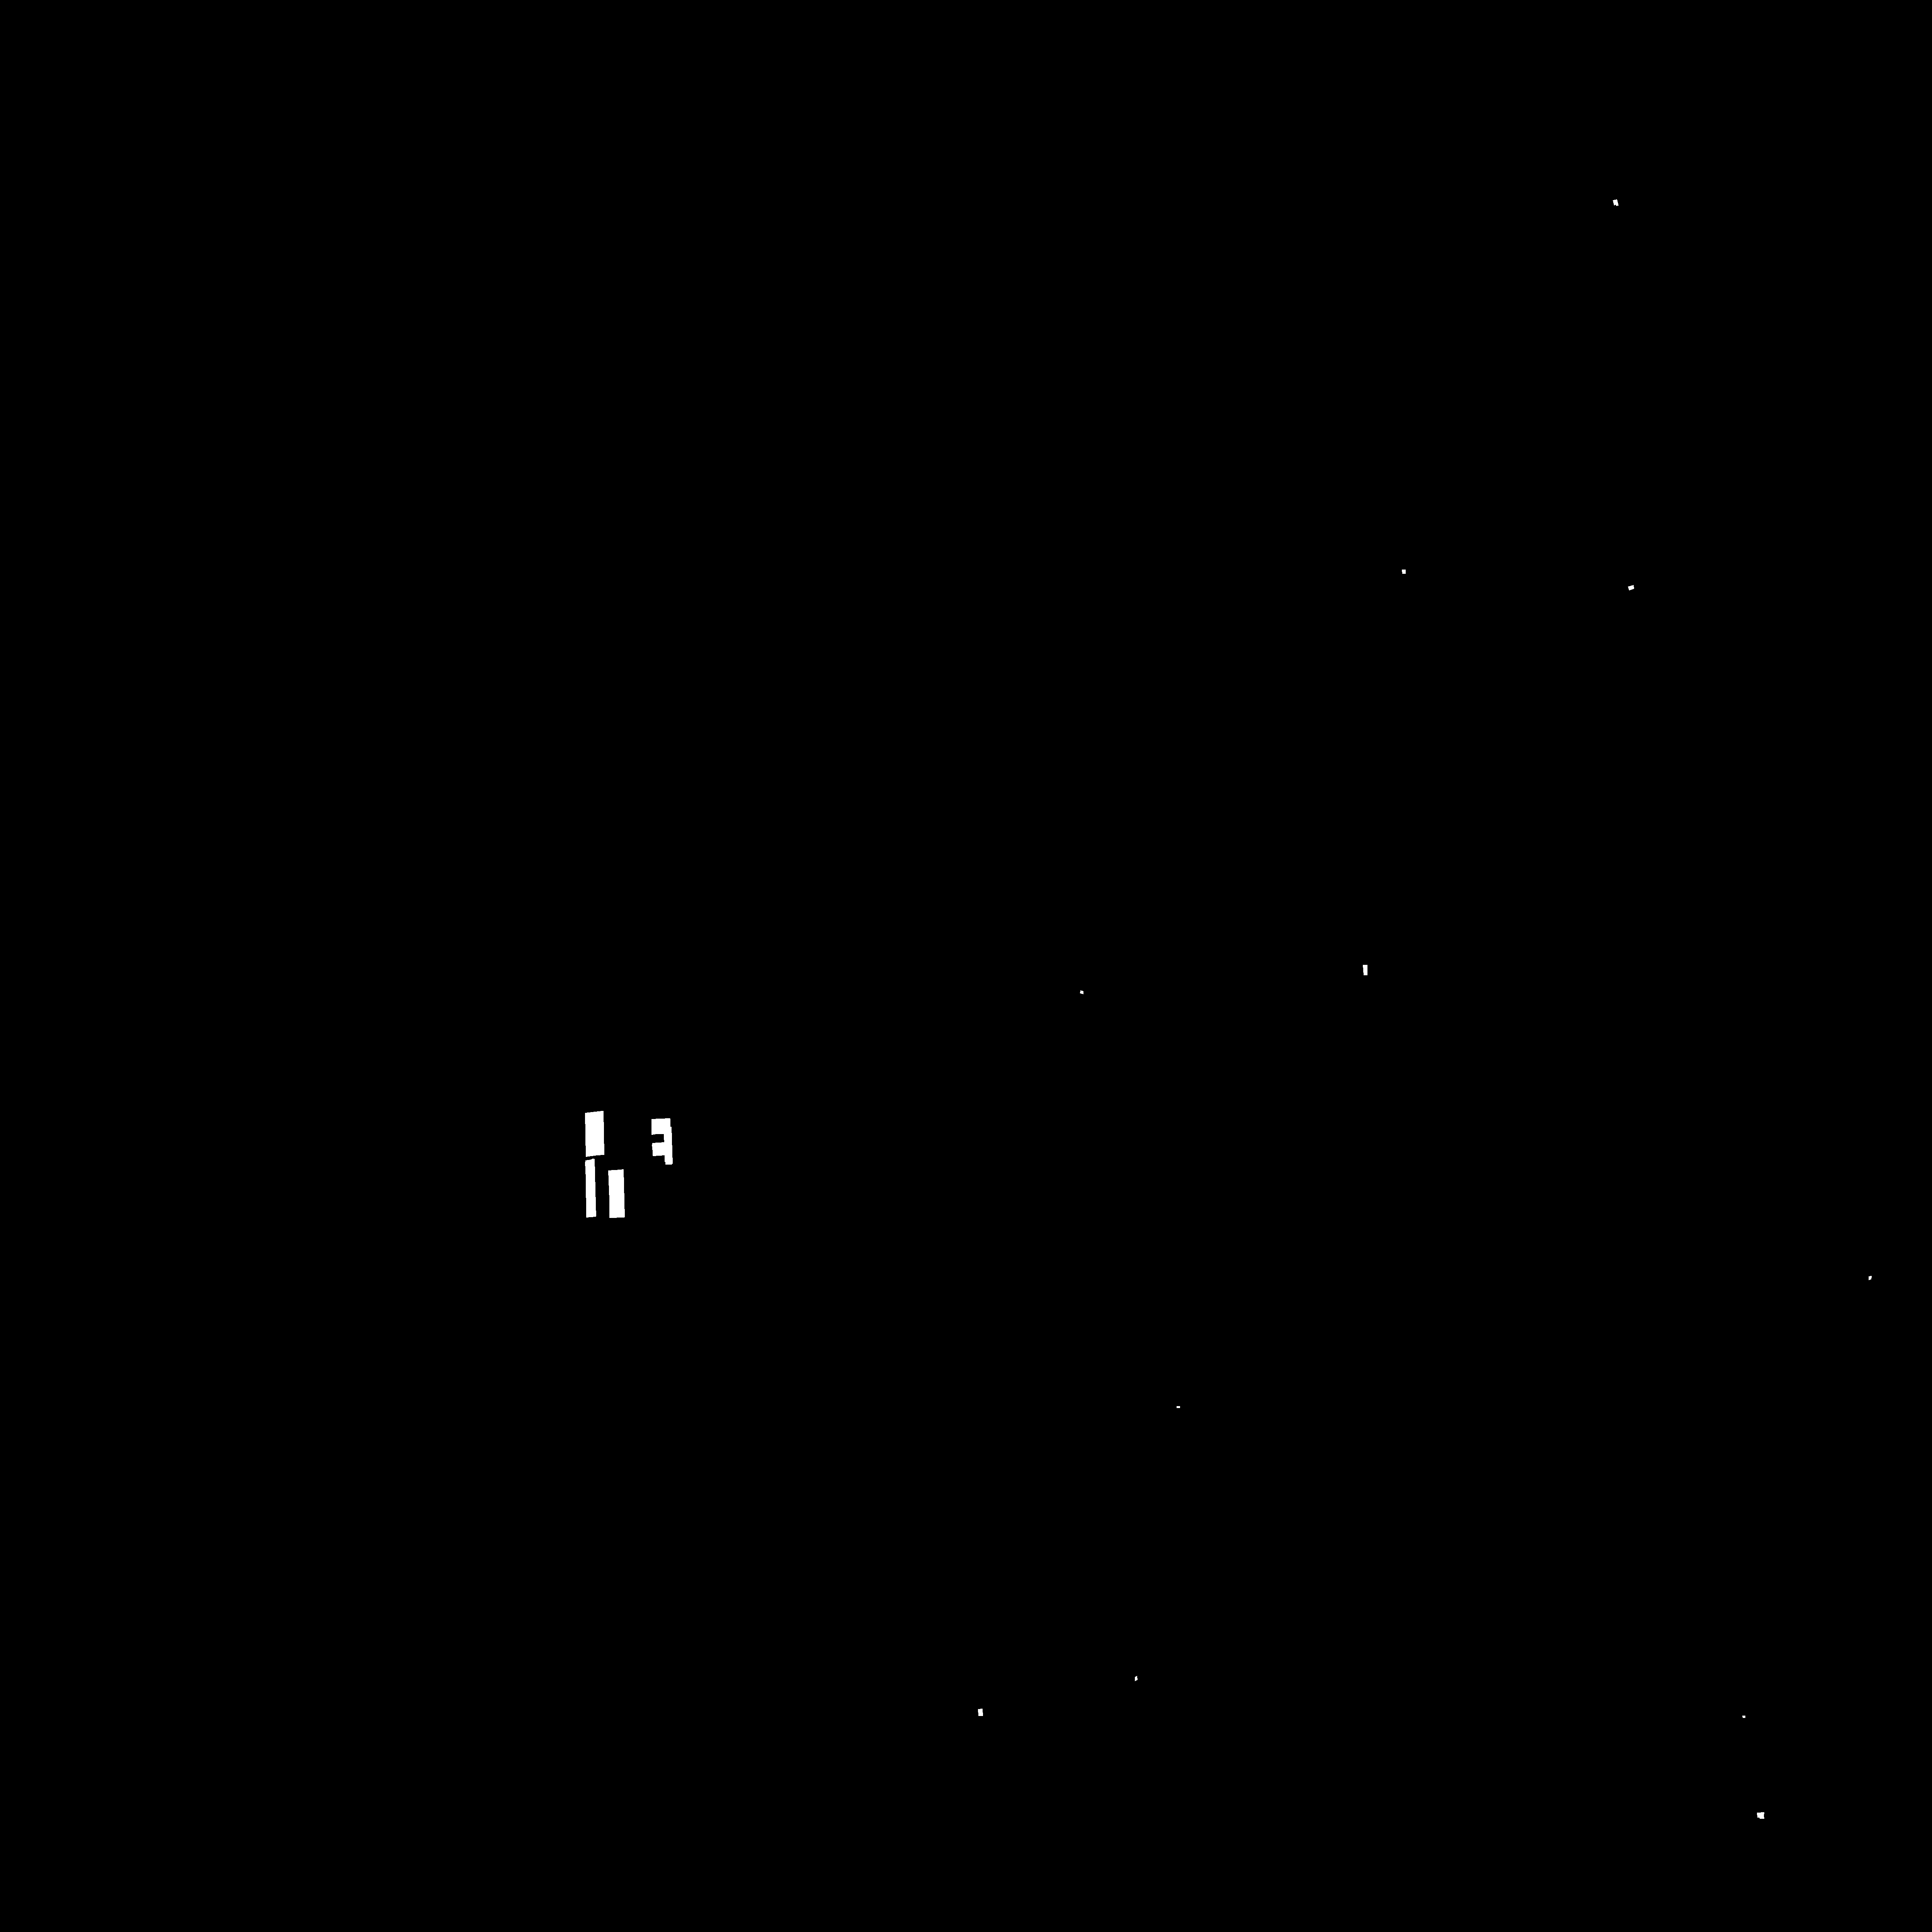

(5000, 5000)
(5000, 5000)


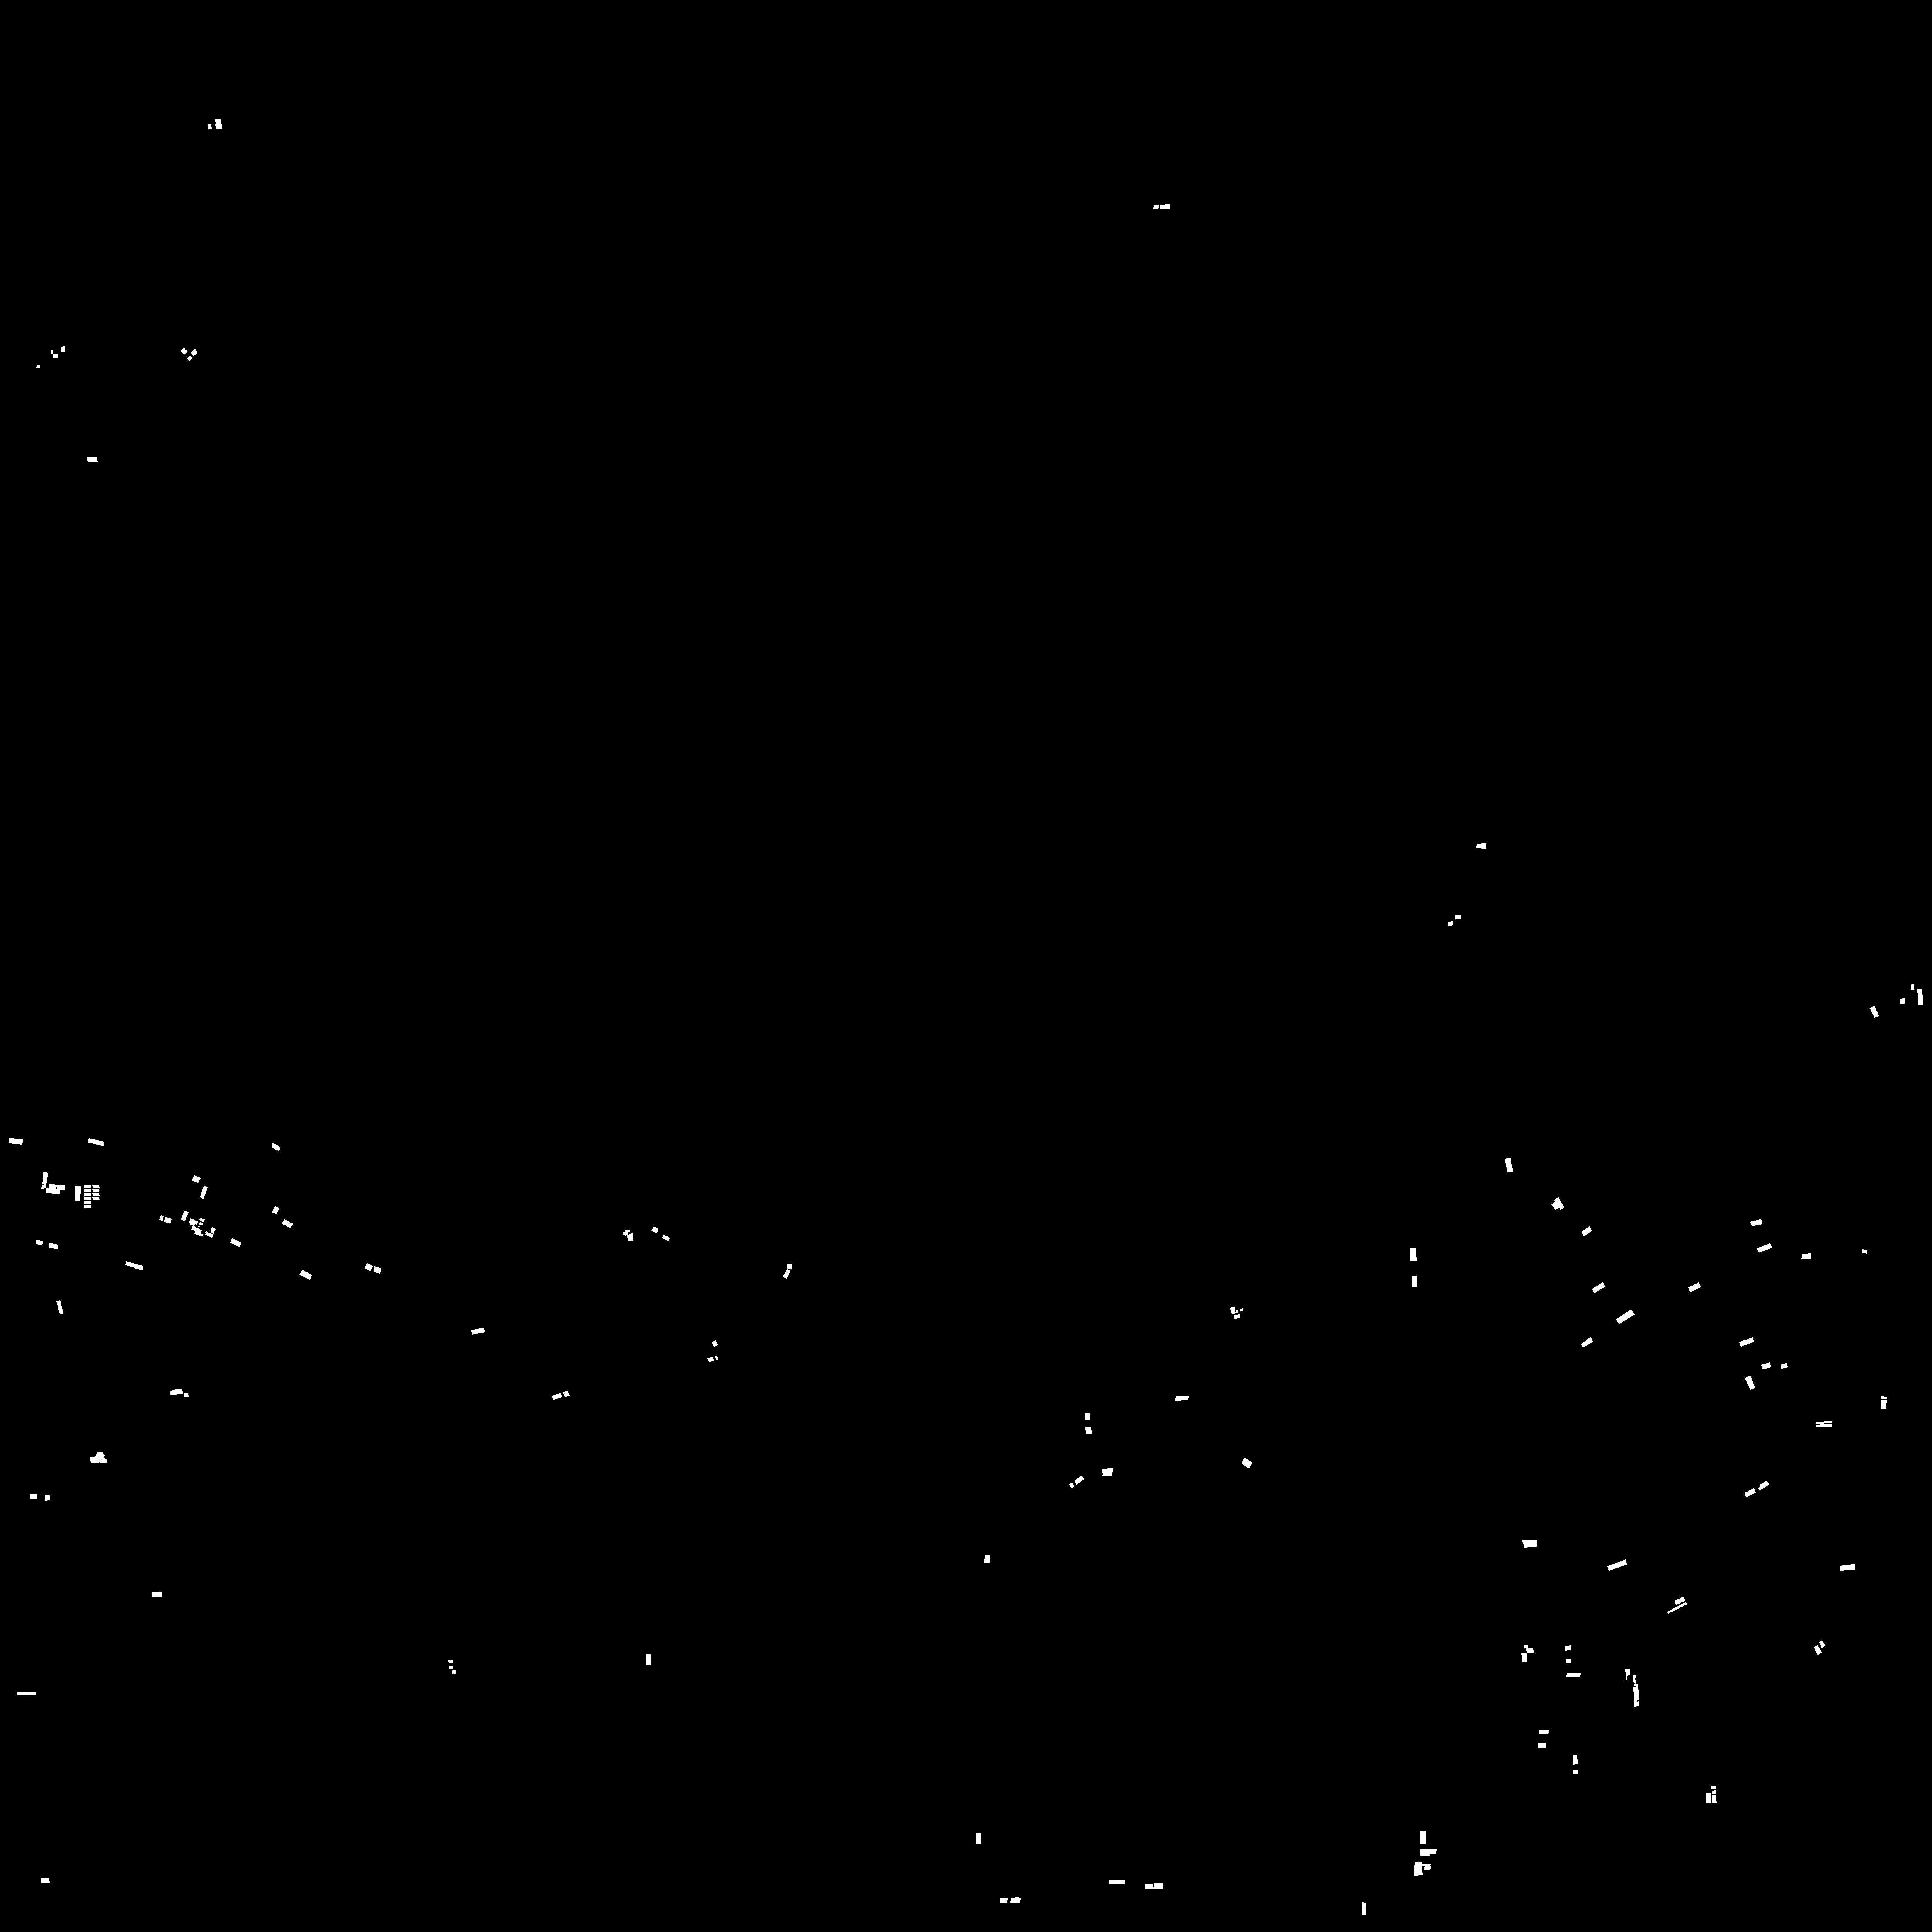

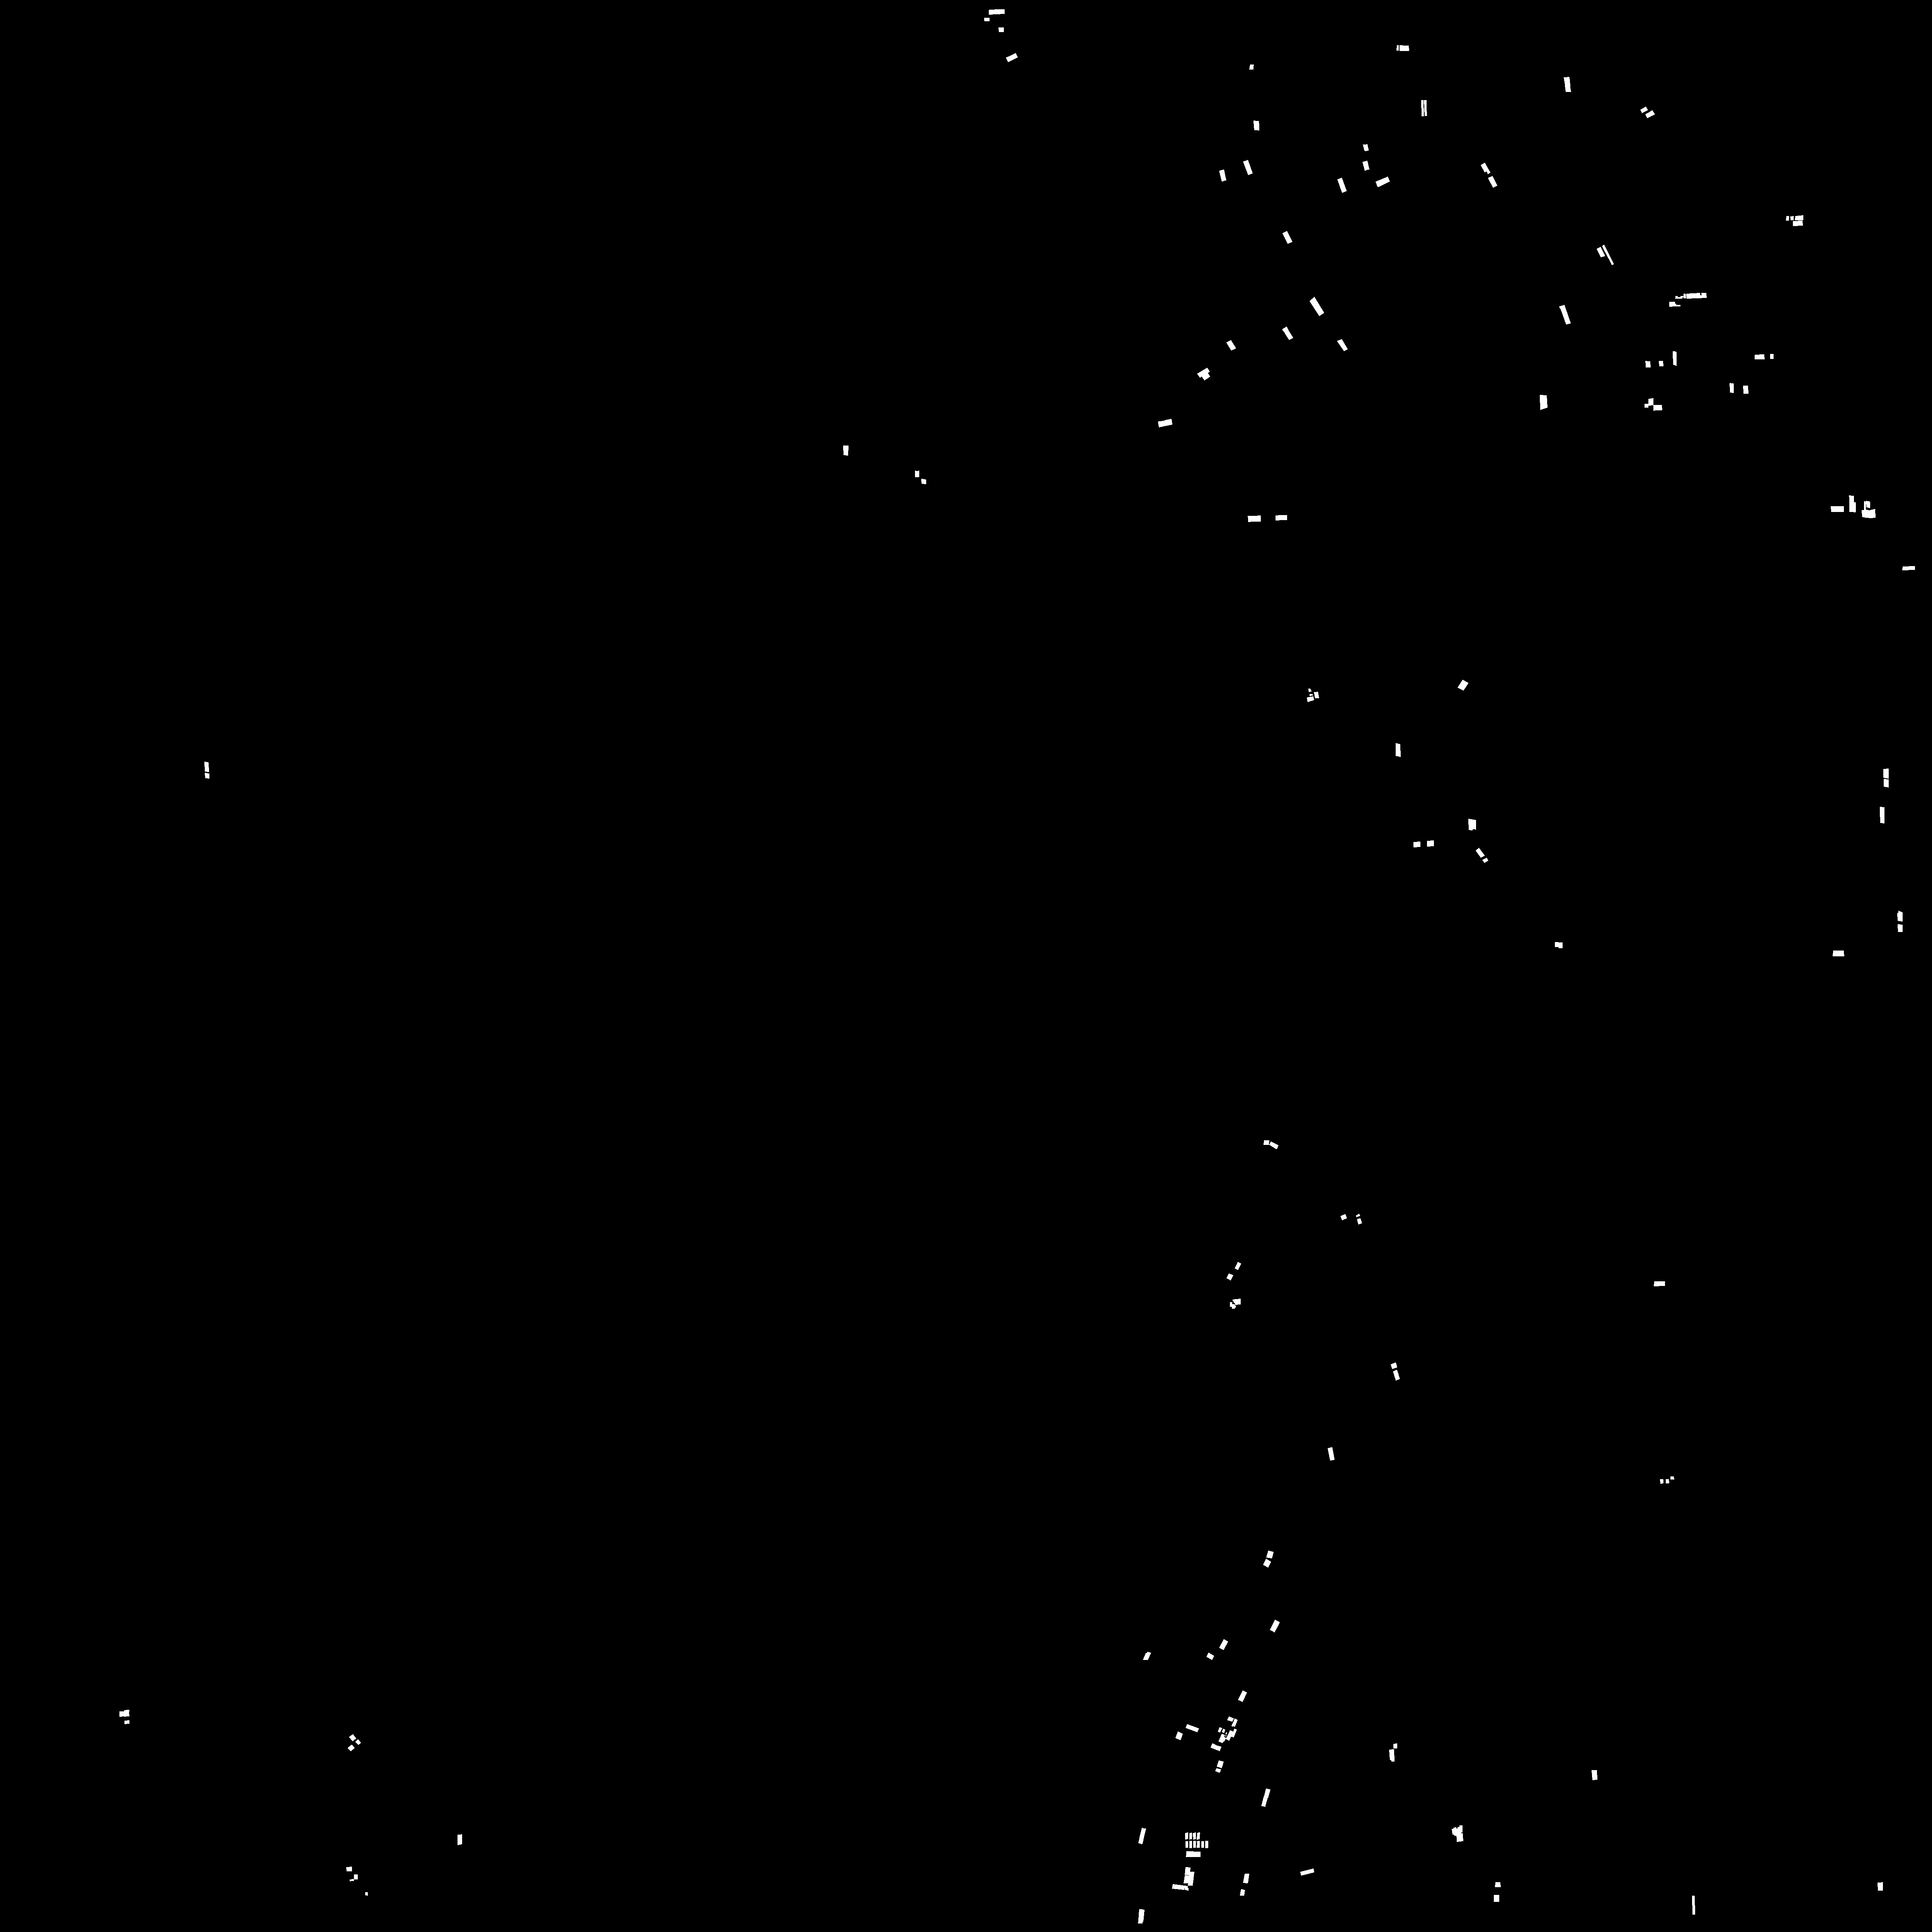

(5000, 5000)
(5000, 5000)


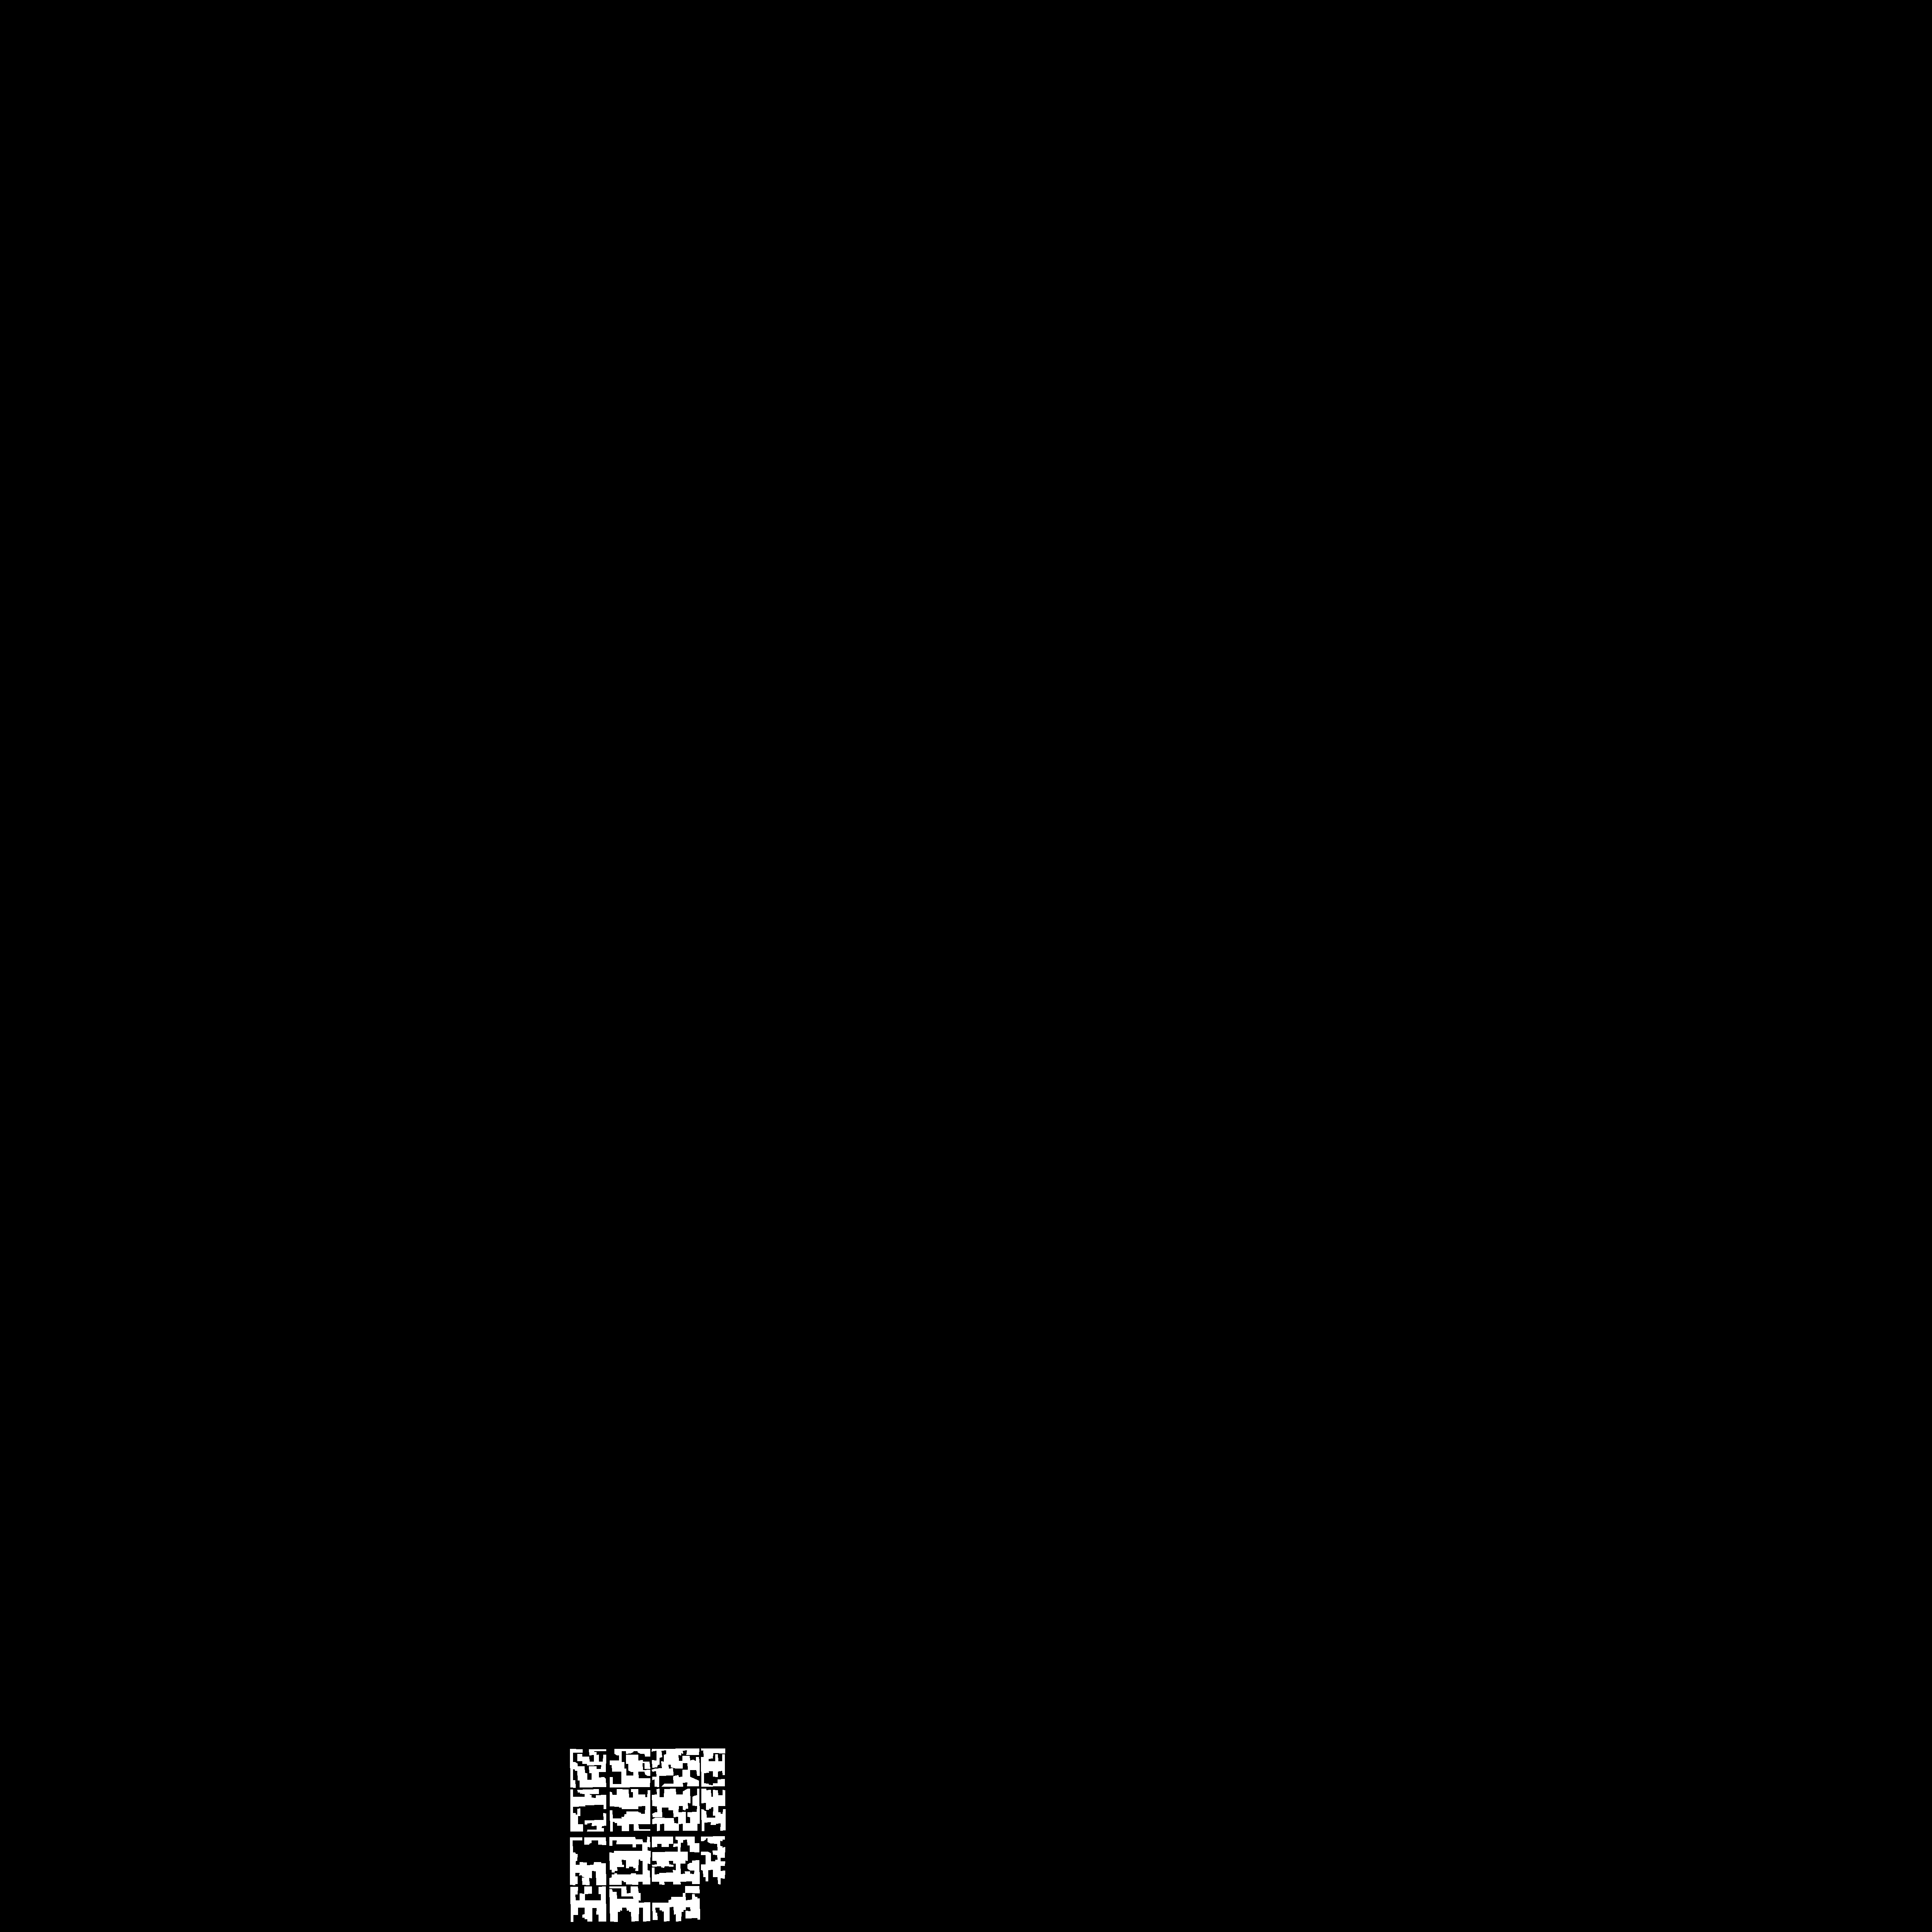

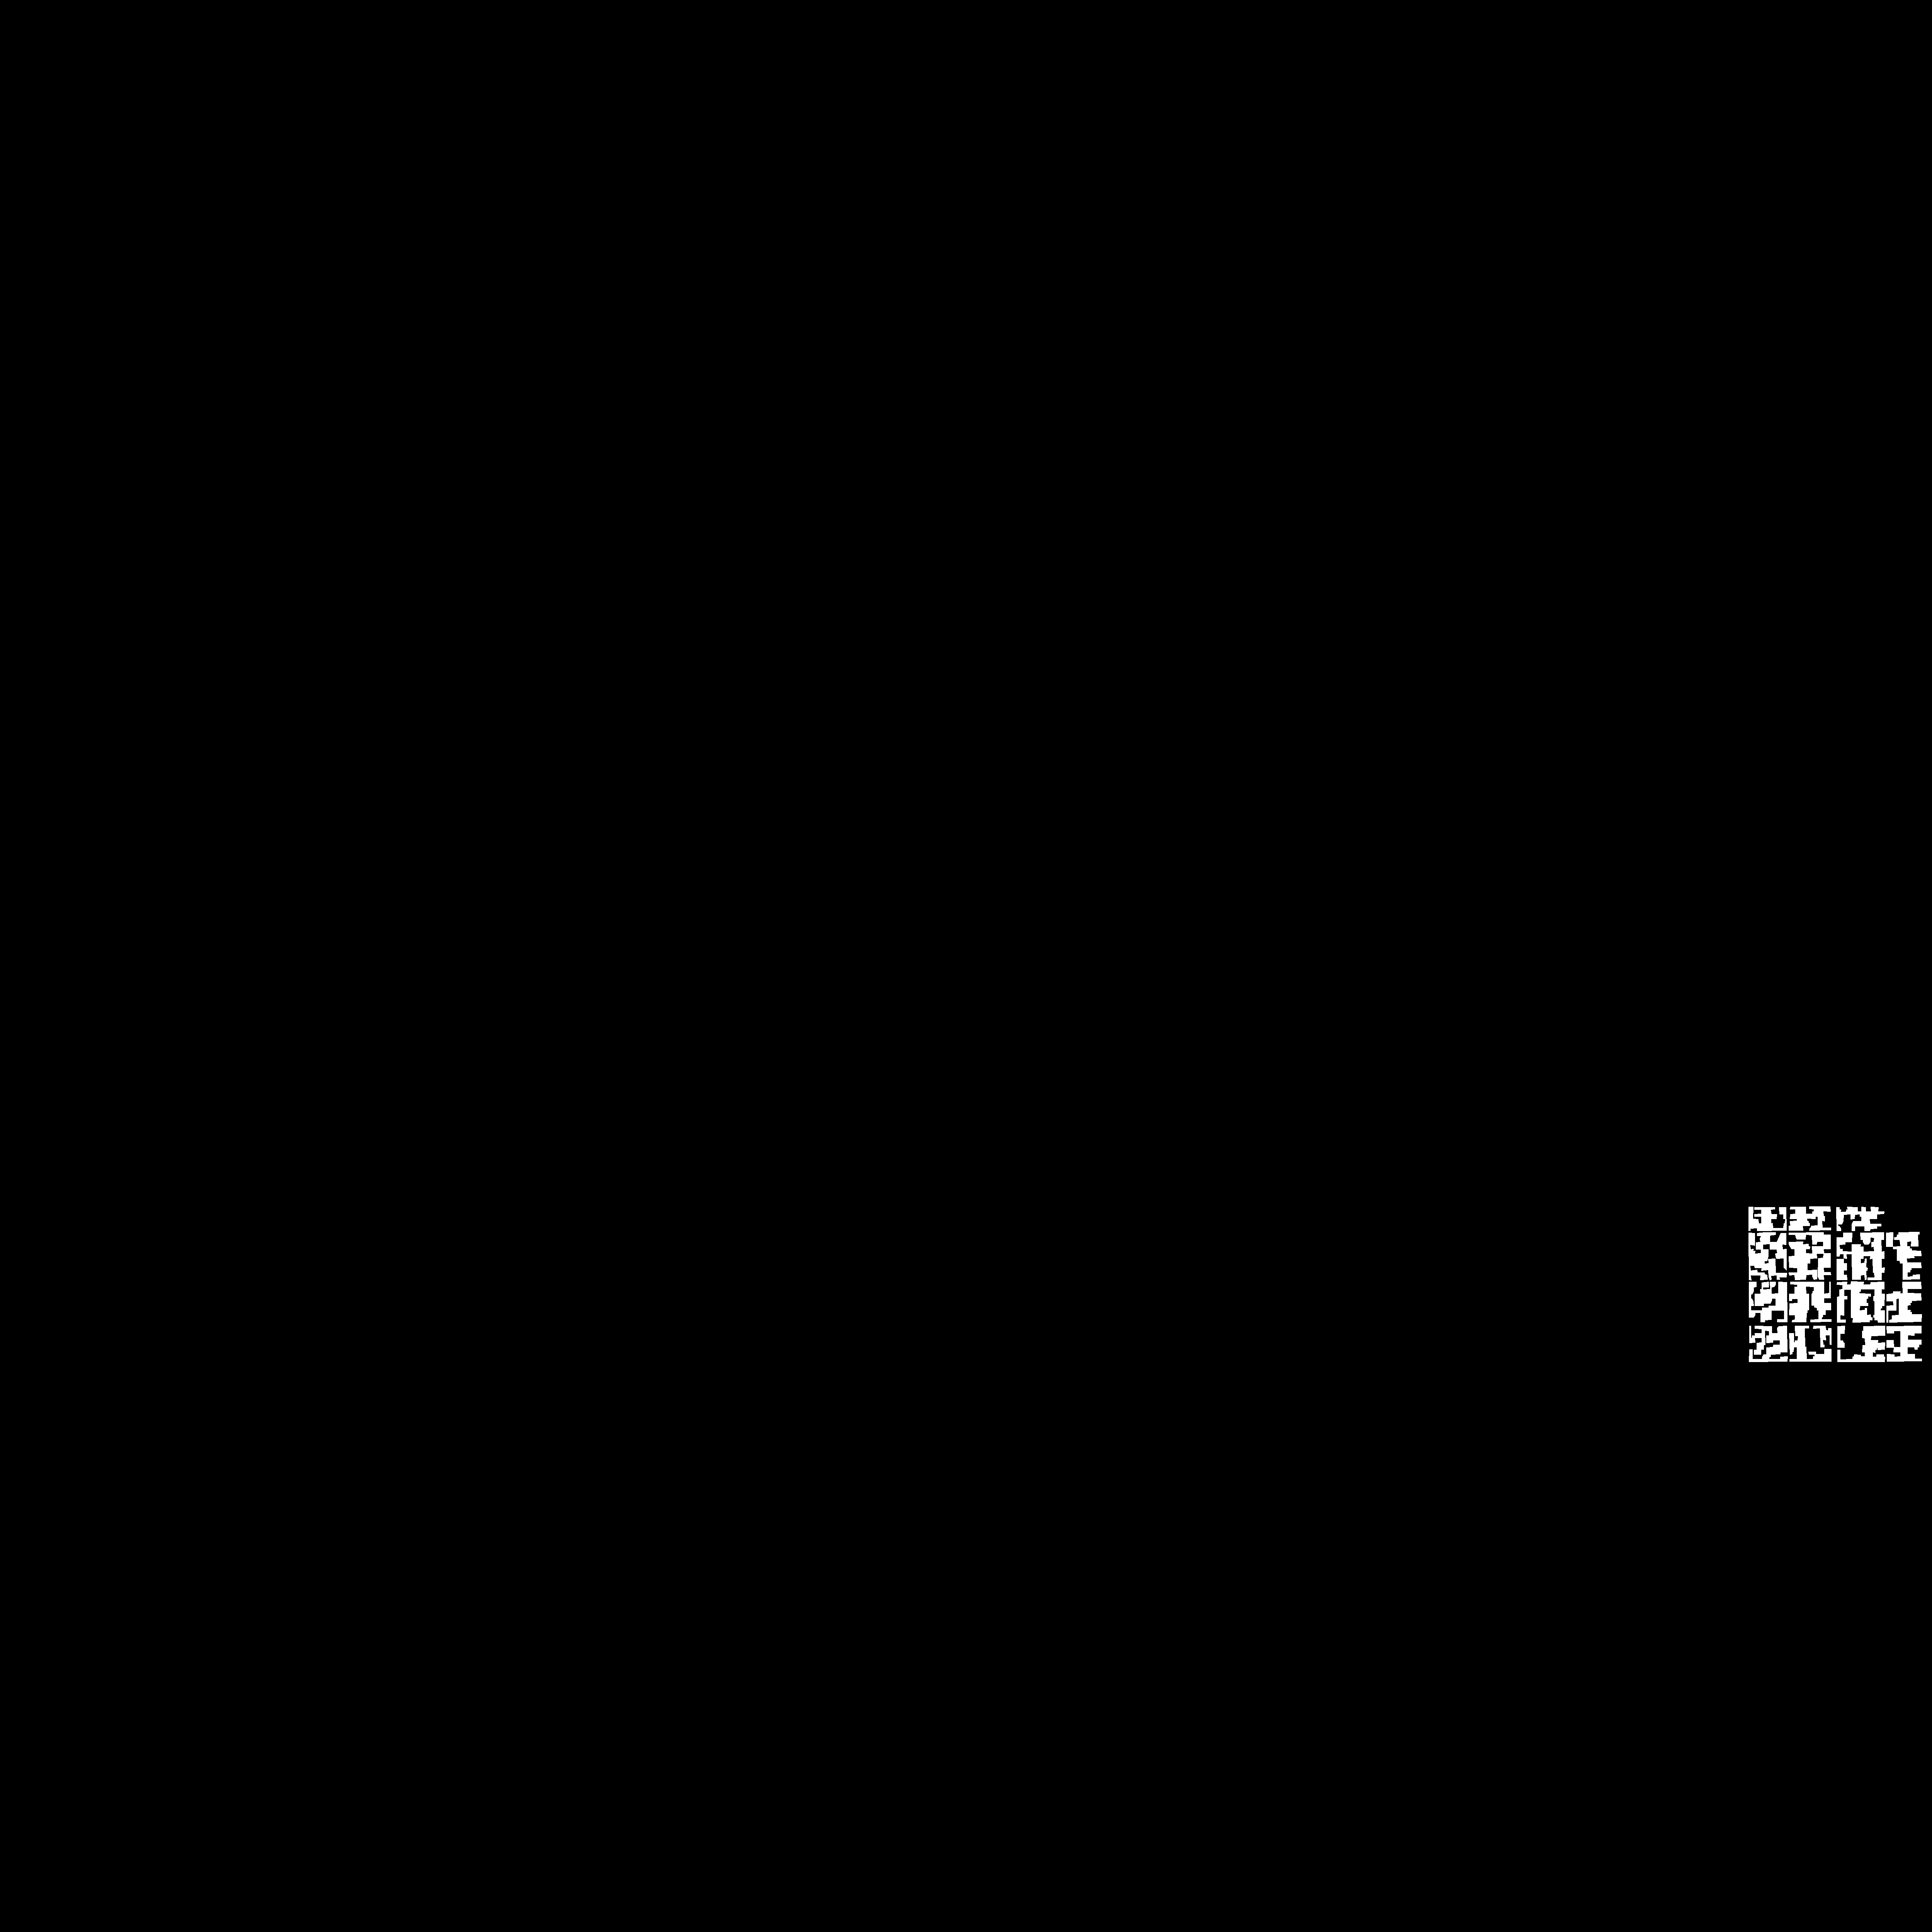

(5000, 5000)
(5000, 5000)


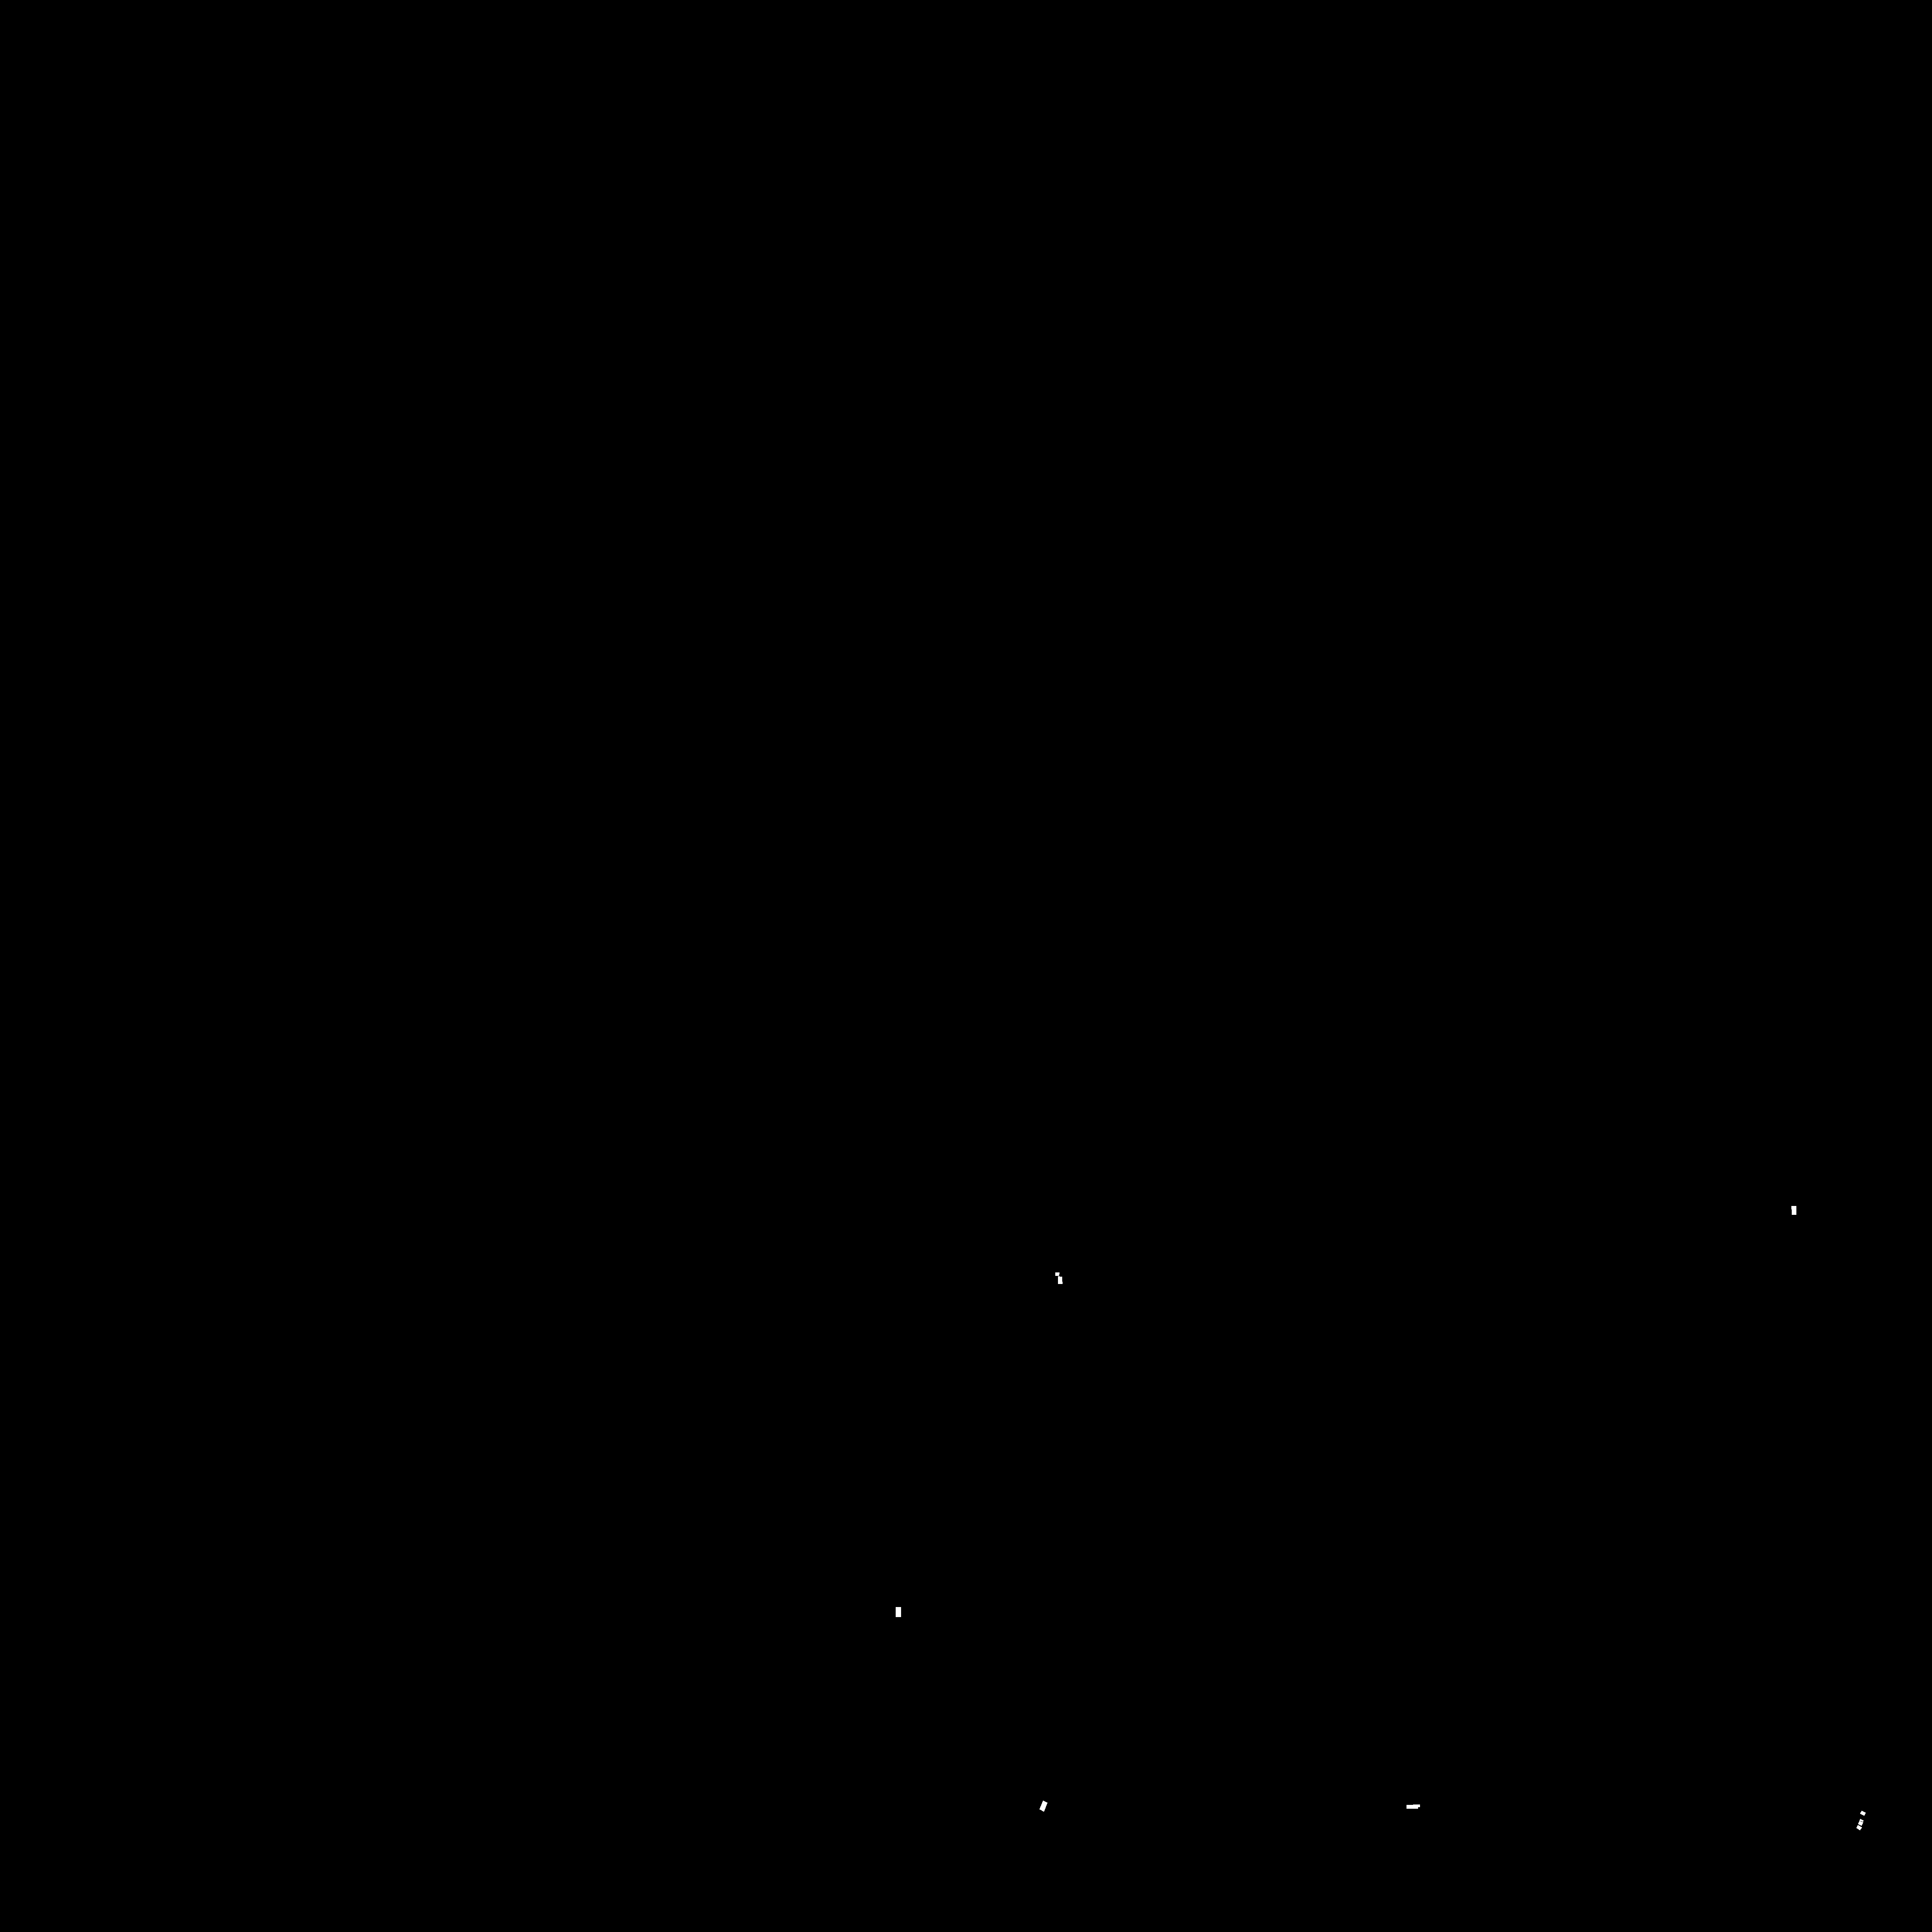

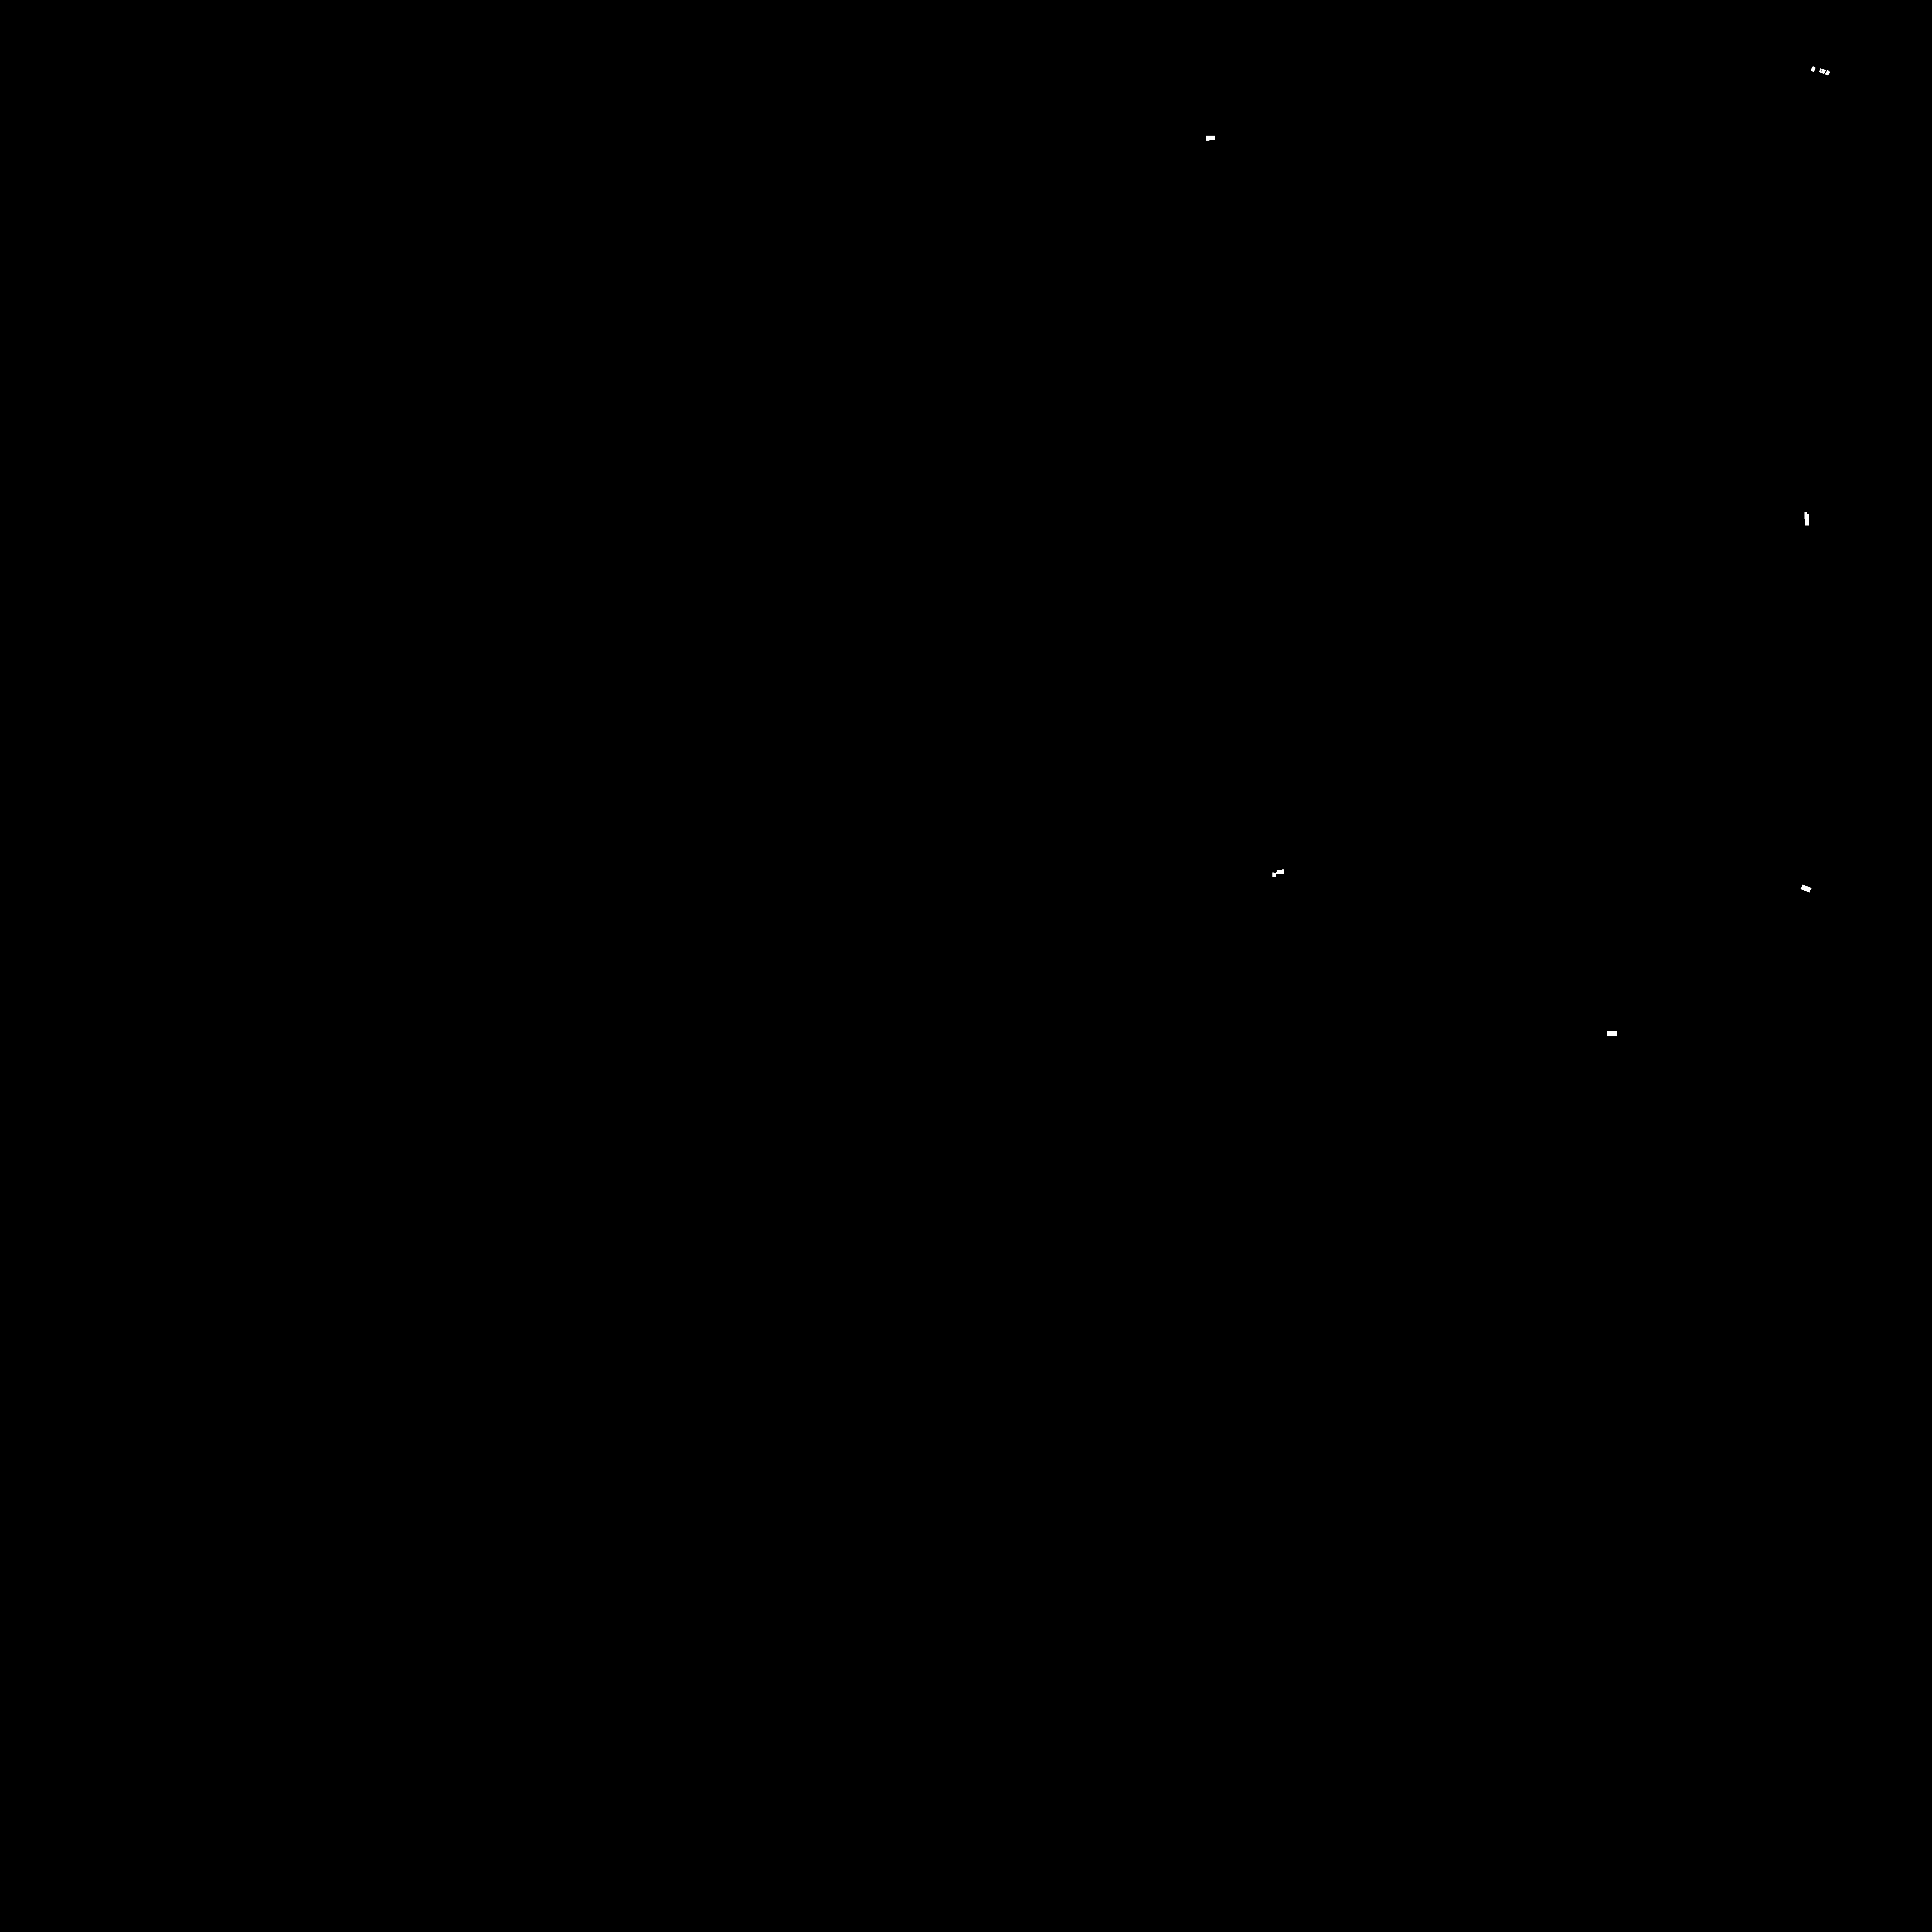

(5000, 5000)
(5000, 5000)


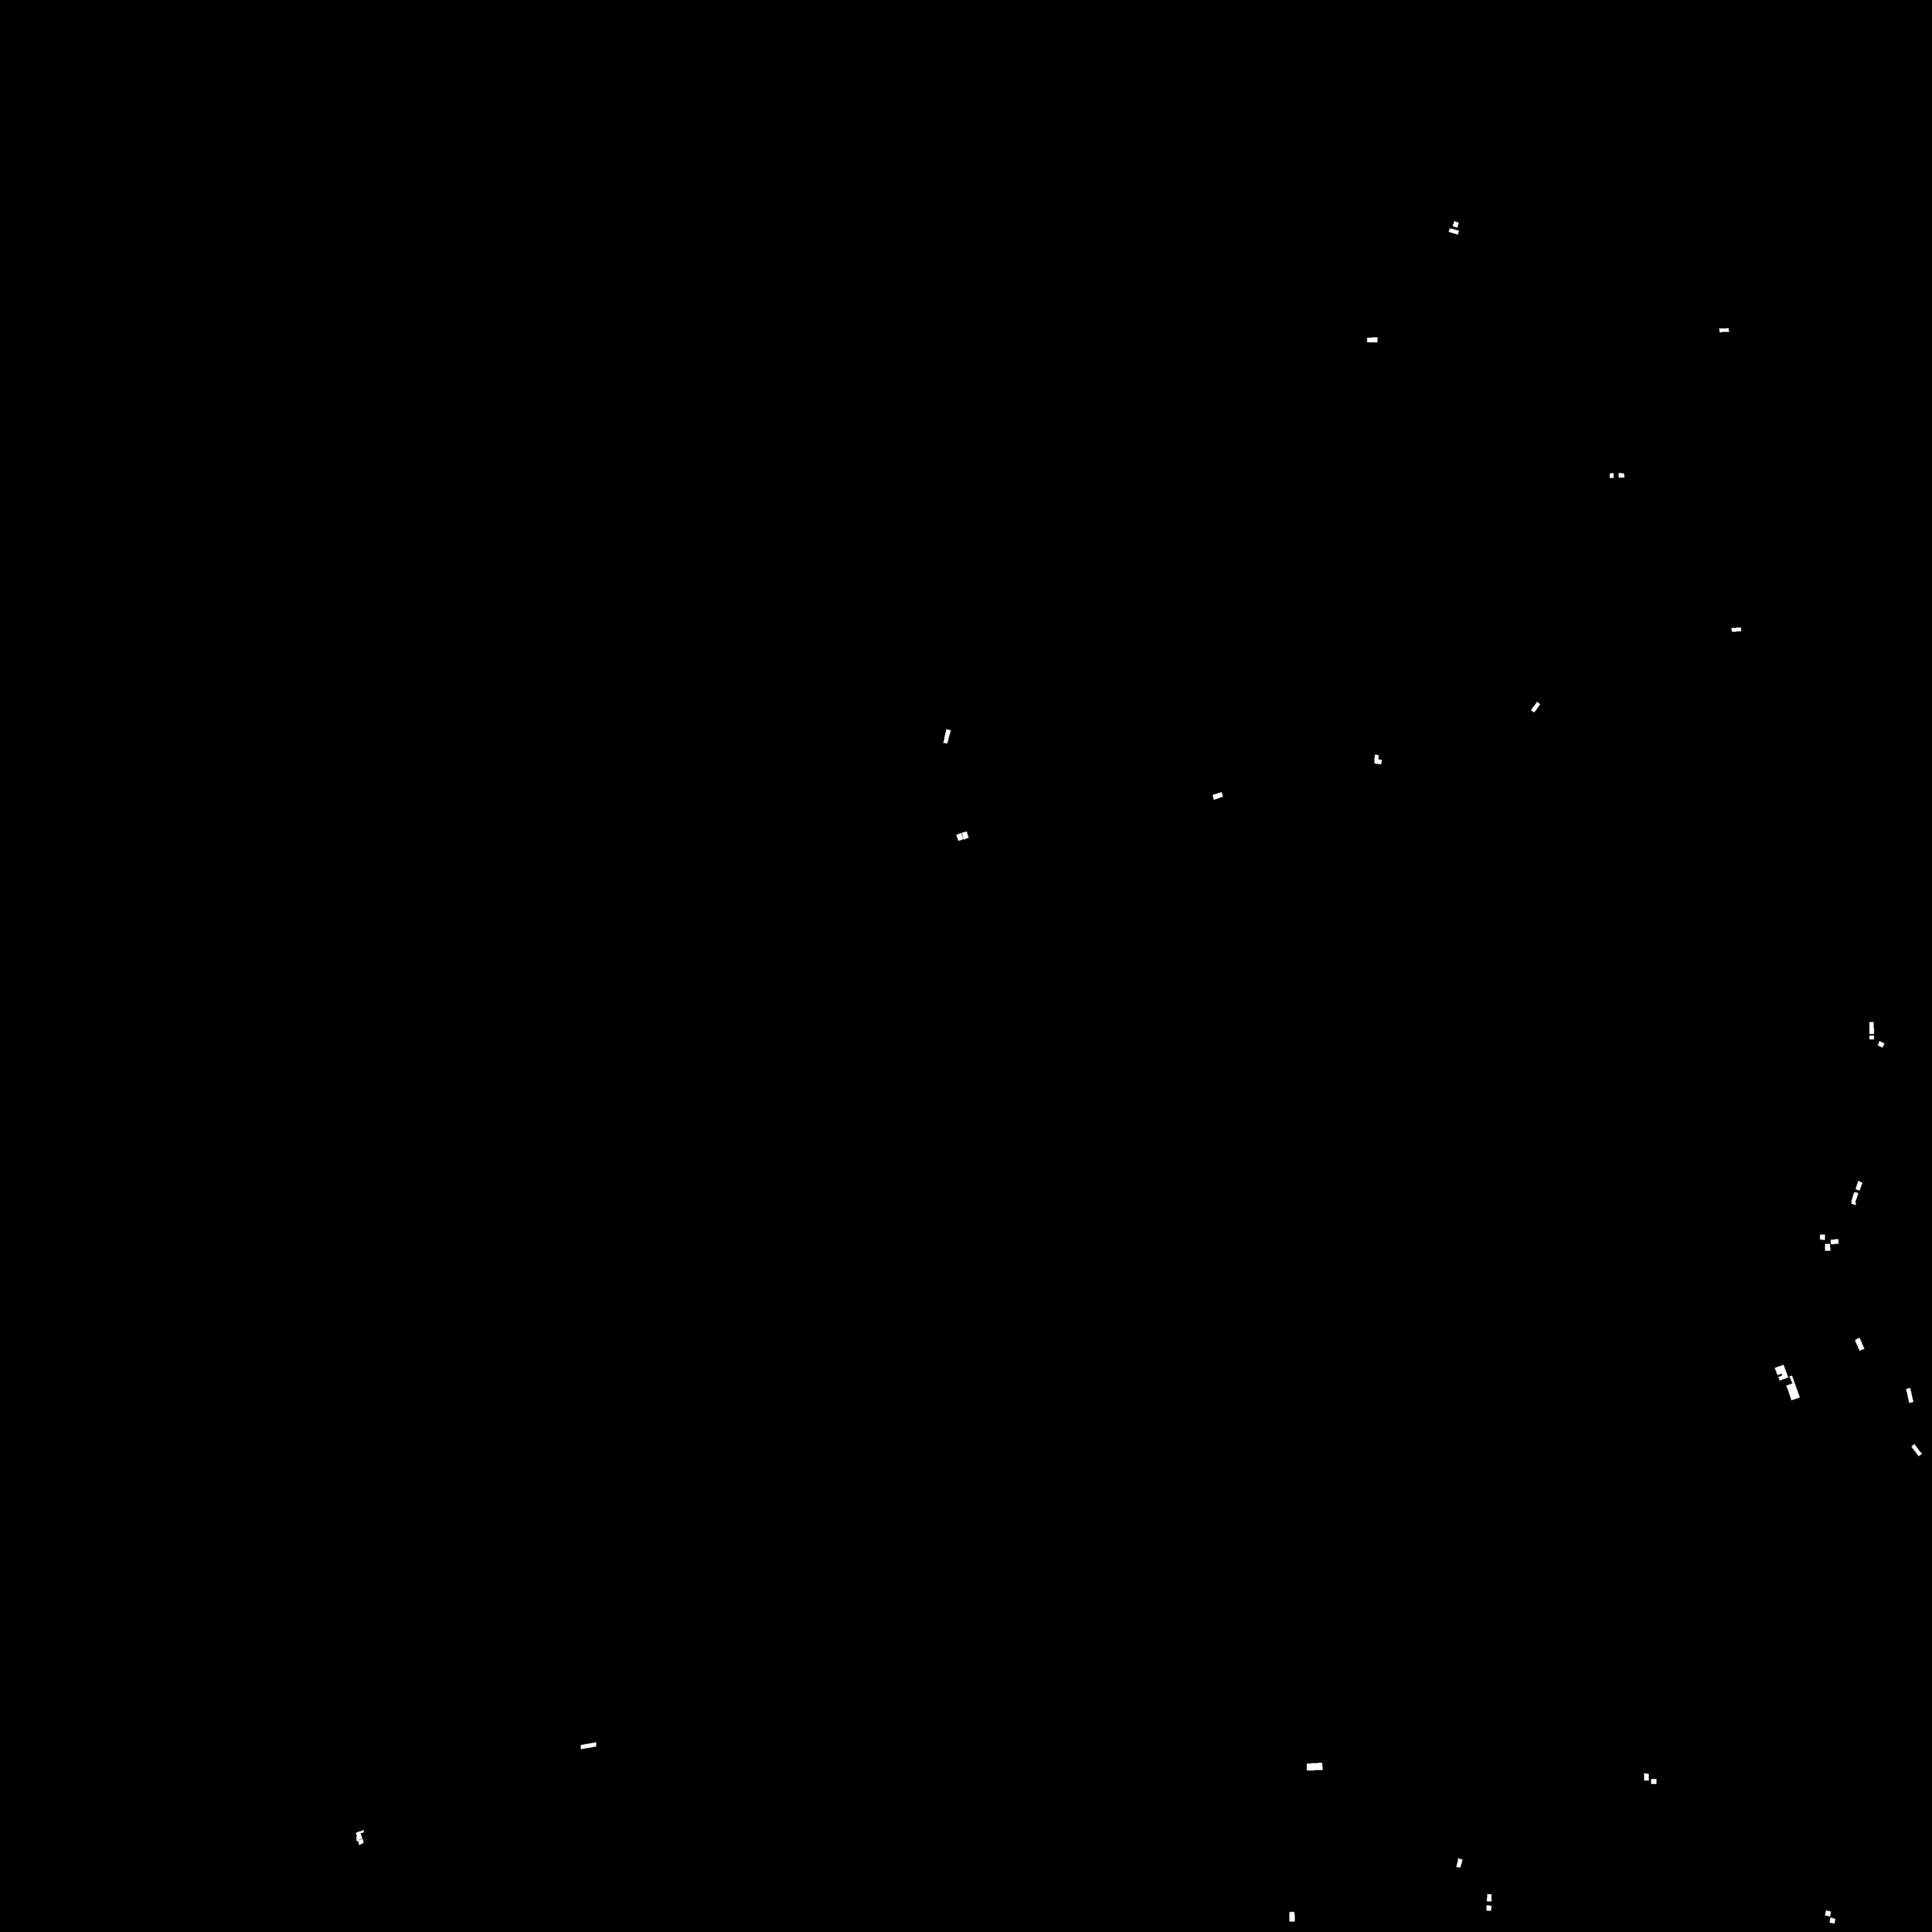

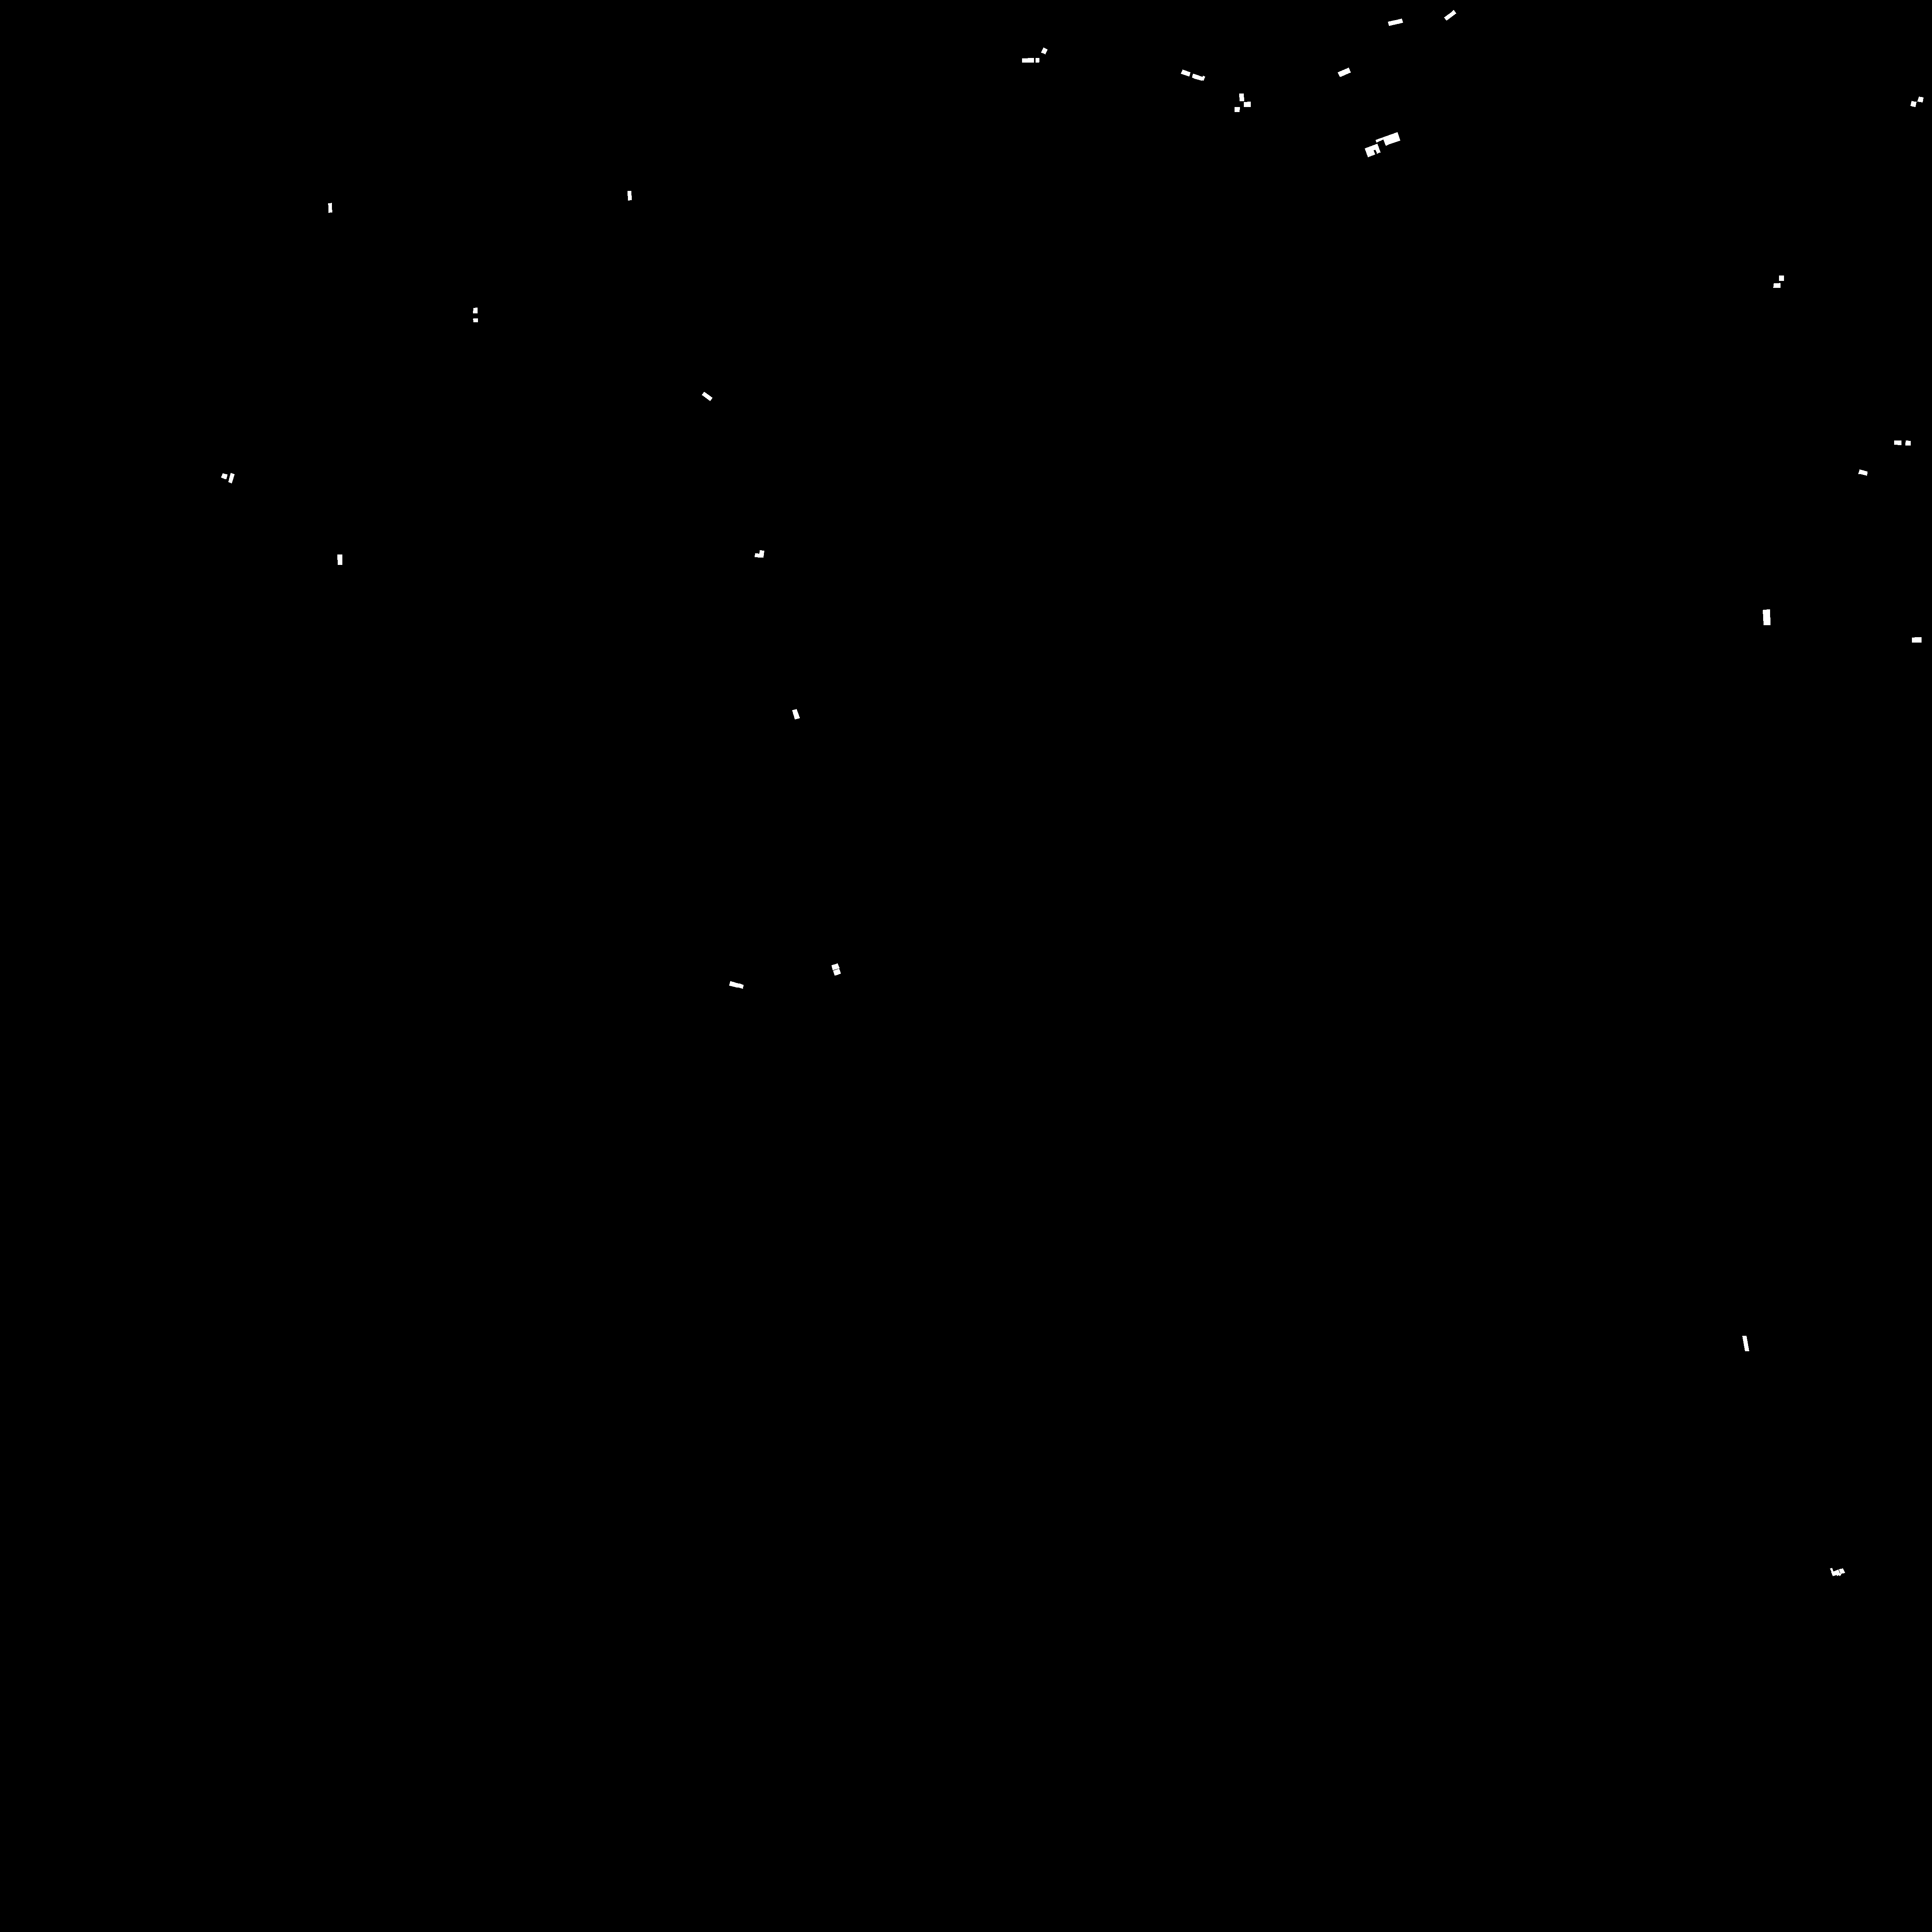

In [ ]:
#Executes generation and saving of binary images
rotate_bin_im()

In [ ]:
#Creating empty rotated binary images 

#Modesto - 0 polygons in image 5, 0 polygons in image 14
#Stockton - 0 polygons in image 20, 25, 32, 33, 34, 51, 54, 55

modesto_file_list = ['10sfg735670','10sfg735685','10sfg750655','10sfg750670','10sfg750685','10sfg765655','10sfg765670','10sfg765685','10sfg780655','10sfg780670','10sfg780685','10sfg795655','10sfg795670','10sfg795685','10sfg810655','10sfg810670','10sfg810685','10sfg825655','10sfg825670','10sfg825685']
empty_modesto_file_list = [modesto_file_list[5], modesto_file_list[14]]
#stockton_file_list = ['10sfh465045','10sfh465030','10sfh465015','10sfh450120','10sfh450105','10sfh450090','10sfh450075','10sfh450060','10sfh450045','10sfh450030','10sfh450015','10sfh450000','10sfh435120','10sfh435105','10sfh435090','10sfh435075','10sfh435060','10sfh435045','10sfh420120','10sfh420105','10sfh420090','10sfh420075','10sfg555985','10sfg555970','10sfg555955','10sfg540985','10sfg540970','10sfg540955','10sfg525985','10sfg525970','10sfg525955','10sfg510985','10sfg510970','10sfg510955','10sfg495985','10sfg495970','10sfg495955','10sfg480985','10sfg480970','10sfg480955','10sfg465985','10sfg465970','10sfh510105','10sfh465075','10sfh525075','10sfh510030','10sfh510045','10sfh540075','10sfh510135','10sfh540060','10sfh480045','10sfh480120','10sfh525015','10sfh555000','10sfh480000','10sfh495120','10sfh495060','10sfh510120','10sfh495030','10sfh540030','10sfh525135','10sfh495105','10sfh480030','10sfh525045','10sfh480015','10sfh495090','10sfh465105','10sfh495045','10sfh525000','10sfh495015','10sfh465120','10sfh480060','10sfh465060','10sfh540015','10sfh495135','10sfh510060','10sfh480075','10sfh510015','10sfh495000','10sfh510090','10sfh540000','10sfh540045','10sfh465090','10sfh525030','10sfh525090','10sfh480105','10sfh480090','10sfh495075','10sfh525120','10sfh510000','10sfh525105','10sfh510075','10sfh525060']
#empty_stockton_im_list = [stockton_file_list[20],stockton_file_list[25],stockton_file_list[32],stockton_file_list[33],stockton_file_list[34],stockton_file_list[51],stockton_file_list[54], stockton_file_list[55]]

#loops over file names of files that contain no polygons, generate placeholder empty binary images
for i in range(0, len(empty_modesto_file_list)):
  file_name = empty_modesto_file_list[i]
  file_num = file_name[5:]
  image = np.zeros((5000,5000))
  im_dim = np.shape(image)
  path_output = "/content/drive/My Drive/CV Project Readings/code/data/Modesto_Binary_Rotated/"
  cv2.imwrite(path_output+'modesto_'+file_num+'_bin_rot90cw.tif', np.uint64(image)) #write out new images
  cv2.imwrite(path_output+'modesto_'+file_num+'_bin_rot180.tif', np.uint64(image)) #write out new images 

##Image Subdivision and Dataset Augmentation

Generation of input images and target images subdividing RGB and binary images  for training and testing.

In [ ]:
#Function for subdividing data to serve as input and groundtruth images for augmented dataset
#Specified for images rotated by 90 degrees based on file naming convention 
def process_groundtruth_bin_im_90(file_name, file_num, im_dim, image, bin_im):

  sub_im_size = 256

  #Define file paths as desired
  output_dir = "/content/drive/My Drive/CV Project Readings/code/data/Binary_Chopped_Concatenated_NoEmptyRegions_Aug/Chopped/"
  output_dir_polygons = "/content/drive/My Drive/CV Project Readings/code/data/Binary_Chopped_Concatenated_NoEmptyRegions_Aug/Chopped/ContainsPolygons/"
  path_output = output_dir 
  path_output_polygons = output_dir_polygons
  
  #image is the rgb image, bin_im is the binary image
  image = image
  im_bg = bin_im

  #need to change city name as necessary depending on data being processed
  #Loops through image subregions
  for i in range (0,int(np.floor(np.shape(im_bg)[0]/sub_im_size))):
    for j in range (0, int(np.floor(np.shape(im_bg)[1]/sub_im_size))):
      #If there is a polygon present
      if (np.max(np.max(im_bg[i*sub_im_size:(i+1)*sub_im_size,j*sub_im_size:(j+1)*sub_im_size]))) > 0:  
        #This threshold stipulates that image subregion must be have at least 5% of its pixels belonging to pv panel
        if (np.sum(np.sum(im_bg[i*sub_im_size:(i+1)*sub_im_size,j*sub_im_size:(j+1)*sub_im_size]))/255) > (.05 * sub_im_size * sub_im_size):
          cv2.imwrite(path_output_polygons+'stockton_'+file_num+'_bin_'+str(i)+'_'+str(j)+'_containsPolygon_rot90cw.tif', np.uint64(im_bg[i*sub_im_size:(i+1)*sub_im_size,j*sub_im_size:(j+1)*sub_im_size]))  
          cv2.imwrite(path_output_polygons+'stockton_'+file_num+'_'+str(i)+'_'+str(j)+'_containsPolygon_rot90cw.tif', image[i*sub_im_size:(i+1)*sub_im_size,j*sub_im_size:(j+1)*sub_im_size])
          list_data = ['stockton_'+file_num+'_bin_'+str(i)+'_'+str(j)+'_containsPolygon_rot90cw.tif','stockton_'+file_num+'_'+str(i)+'_'+str(j)+'_containsPolygon_rot90cw.tif']
          #write corresponding binary and rgb subimage file names in csv for use by train loader
          with open(path_output_polygons+'csv_file.csv', 'a', newline='') as f_object:  
            csv_object = writer(f_object)
            csv_object.writerow(list_data) 
            f_object.close()
  

In [ ]:
#Function for subdividing data to serve as input and groundtruth images for augmented dataset
#As function above, but for rotation of images by 180 degrees based on naming convention
def process_groundtruth_bin_im_180(file_name, file_num, im_dim, image, bin_im):

  sub_im_size = 256

  output_dir = "/content/drive/My Drive/CV Project Readings/code/data/Binary_Chopped_Concatenated_NoEmptyRegions_Aug/Chopped/"
  output_dir_polygons = "/content/drive/My Drive/CV Project Readings/code/data/Binary_Chopped_Concatenated_NoEmptyRegions_Aug/Chopped/ContainsPolygons/"
  path_output = output_dir 
  path_output_polygons = output_dir_polygons
  
  image = image
  im_bg = bin_im
  #print(np.shape(im_bg))

  for i in range (0,int(np.floor(np.shape(im_bg)[0]/sub_im_size))):
    for j in range (0, int(np.floor(np.shape(im_bg)[1]/sub_im_size))):
      if (np.max(np.max(im_bg[i*sub_im_size:(i+1)*sub_im_size,j*sub_im_size:(j+1)*sub_im_size]))) > 0:
        if (np.sum(np.sum(im_bg[i*sub_im_size:(i+1)*sub_im_size,j*sub_im_size:(j+1)*sub_im_size]))/255) > (.05 * sub_im_size * sub_im_size):
          cv2.imwrite(path_output_polygons+'stockton_'+file_num+'_bin_'+str(i)+'_'+str(j)+'_containsPolygon_rot180.tif', np.uint64(im_bg[i*sub_im_size:(i+1)*sub_im_size,j*sub_im_size:(j+1)*sub_im_size]))  
          cv2.imwrite(path_output_polygons+'stockton_'+file_num+'_'+str(i)+'_'+str(j)+'_containsPolygon_rot180.tif', image[i*sub_im_size:(i+1)*sub_im_size,j*sub_im_size:(j+1)*sub_im_size])
          list_data = ['stockton_'+file_num+'_bin_'+str(i)+'_'+str(j)+'_containsPolygon_rot180.tif','stockton_'+file_num+'_'+str(i)+'_'+str(j)+'_containsPolygon_rot180.tif']
          with open(path_output_polygons+'csv_file.csv', 'a', newline='') as f_object:  
            csv_object = writer(f_object)
            csv_object.writerow(list_data) 
            f_object.close()

In [ ]:
#Stockton - 0 polygons in image 20, 25, 32, 33, 34, 51, 54, 55

#Loops through images to generate augmented dataset
#Change file names, file list input, file paths, and index ranges as desired
def loop_ims(stockton_file_list):
  path_input ="/content/drive/My Drive/CV Project Readings/code/data/Stockton_Aerial_USGS_Imagery_Rotated/"
  path_input_2 ="/content/drive/My Drive/CV Project Readings/code/data/Stockton_Binary_Rotated/"
  for i in range(56, len(stockton_file_list)): 
    file_name = stockton_file_list[i]
    file_num = file_name[5:]
    #read rgb image rotated by 180 degrees
    image_orig = cv2.imread(path_input+file_name+'_rot180.tif', cv2.IMREAD_UNCHANGED)  
    im_dim = np.shape(image_orig)
    #read binary image rotated by 180 degrees
    image_bin = cv2.imread(path_input_2+'stockton_'+file_num+'_bin_rot180.tif', cv2.IMREAD_UNCHANGED)
    #generate images, groundtruth for augmented dataset using images rotated by 180 degrees
    process_groundtruth_bin_im_180(file_name, file_num, im_dim, image_orig,image_bin)
    #read rgb image rotated by 90 degrees
    image = cv2.imread(path_input+file_name+'_rot90cw.tif', cv2.IMREAD_UNCHANGED)  
    im_dim = np.shape(image)
    #read binary image rotated by 90 degrees
    image_bin = cv2.imread(path_input_2+'stockton_'+file_num+'_bin_rot90cw.tif', cv2.IMREAD_UNCHANGED)
    #generate images, groundtruth for augmented dataset using images rotated by 90 degrees
    process_groundtruth_bin_im_90(file_name, file_num, im_dim, image,image_bin)


In [ ]:
#execute loop to generate input and target images 
loop_ims(stockton_file_list)

(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)


In [ ]:
#Notes on Modesto and Stockton datasets
#modesto_file_list = ['10sfg735670','10sfg735685','10sfg750655','10sfg750670','10sfg750685','10sfg765655','10sfg765670','10sfg765685','10sfg780655','10sfg780670','10sfg780685','10sfg795655','10sfg795670','10sfg795685','10sfg810655','10sfg810670','10sfg810685','10sfg825655','10sfg825670','10sfg825685']
#stockton_file_list = ['10sfh465045','10sfh465030','10sfh465015','10sfh450120','10sfh450105','10sfh450090','10sfh450075','10sfh450060']

#Modesto - 0 polygons in image 5, 0 polygons in image 14
#Stockton - 0 polygons in image 20, 25, 32, 33, 34, 51, 54, 55

##Processing Non-Rotated Images Using Pre-generated Binary Images

In the functions above we generated the subdivided input images and corresponding binary images for the rotated images contributing to the augmented dataset. Now we generate the input and target images for the non-rotated images that serves as the baseline dataset and is also combined with the rotated images to form the augmented dataset.

In [ ]:
#Generates input and target subimages using non-rotated images
#Defined as a separate function for file naming convention
def process_groundtruth_bin_im_noRot(file_name, file_num, im_dim, image, bin_im):

  sub_im_size = 256

  output_dir = "/content/drive/My Drive/CV Project Readings/code/data/Binary_Chopped_Concatenated_NoEmptyRegions_Aug/Chopped/"
  output_dir_polygons = "/content/drive/My Drive/CV Project Readings/code/data/Binary_Chopped_Concatenated_NoEmptyRegions_Aug/Chopped/ContainsPolygons/"
  path_output = output_dir
  path_output_polygons = output_dir_polygons
  
  image = image
  im_bg = bin_im
  #print(np.shape(im_bg))

  for i in range (0,int(np.floor(np.shape(im_bg)[0]/sub_im_size))):
    for j in range (0, int(np.floor(np.shape(im_bg)[1]/sub_im_size))):
      if (np.max(np.max(im_bg[i*sub_im_size:(i+1)*sub_im_size,j*sub_im_size:(j+1)*sub_im_size]))) > 0:
        if (np.sum(np.sum(im_bg[i*sub_im_size:(i+1)*sub_im_size,j*sub_im_size:(j+1)*sub_im_size]))/255) > (.05 * sub_im_size * sub_im_size):
          cv2.imwrite(path_output_polygons+'stockton_'+file_num+'_bin_'+str(i)+'_'+str(j)+'_containsPolygon.tif', np.uint64(im_bg[i*sub_im_size:(i+1)*sub_im_size,j*sub_im_size:(j+1)*sub_im_size])) #write out new images 
          cv2.imwrite(path_output_polygons+'stockton_'+file_num+'_'+str(i)+'_'+str(j)+'_containsPolygon.tif', image[i*sub_im_size:(i+1)*sub_im_size,j*sub_im_size:(j+1)*sub_im_size])
          list_data = ['stockton_'+file_num+'_bin_'+str(i)+'_'+str(j)+'_containsPolygon.tif','stockton_'+file_num+'_'+str(i)+'_'+str(j)+'_containsPolygon.tif']
          with open(path_output_polygons+'csv_file.csv', 'a', newline='') as f_object:  
            csv_object = writer(f_object)
            csv_object.writerow(list_data) 
            f_object.close()

In [ ]:
#Modesto - 0 polygons in image 5, 0 polygons in image 14
#Stockton - 0 polygons in image 20, 25, 32, 33, 34, 51, 54, 55

#Loops through file name list to generate input and target subimages for each image in a given city's dataset
#Need to change file name, path, and for loop ranges accordingly 
def loop_ims(stockton_file_list):
  path_input ="/content/drive/My Drive/CV Project Readings/code/data/Stockton_Aerial_USGS_Imagery/"
  path_input_2 ="/content/drive/My Drive/CV Project Readings/code/data/Stockton_Binary/"
  for i in range(56, len(stockton_file_list)): #len(modesto_file_list)):
    file_name = stockton_file_list[i]
    file_num = file_name[5:]
    image_orig = cv2.imread(path_input+file_name+'.tif', cv2.IMREAD_UNCHANGED) #TO DO - need a nice way to loop through all of the images; may need to rename to have them names more clearly sequential 
    im_dim = np.shape(image_orig)
    image_bin = cv2.imread(path_input_2+'stockton_'+file_num+'_bin.tif', cv2.IMREAD_UNCHANGED)
    process_groundtruth_bin_im_noRot(file_name, file_num, im_dim, image_orig,image_bin)

In [ ]:
#Executes the loop defined above to generate input and target images of non-rotated data
loop_ims(stockton_file_list)

(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
(5000, 5000)
